# Chinese Automobile Company - Geely


A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts. 

 They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. The company wants to know:

Which variables are significant in predicting the price of a car
How well those variables describe the price of a car

## Business Goal 

You are required to model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market. 

 

## Data Preparation

There is a variable named CarName which is comprised of two parts - the first word is the name of 'car company' and the second is the 'car model'. For example, chevrolet impala has 'chevrolet' as the car company name and 'impala' as the car model name. You need to consider only company name as the independent variable for model building. 
 

## Model Evaluation:

When you're done with model building and residual analysis, and have made predictions on the test set, just make sure you use the following two lines of code to calculate the R-squared score on the test set.<br><br>
<b><i>from sklearn.metrics import r2_score <br>
r2_score(y_test, y_pred)</i></b>

## Importing libs and creating common utility functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn.model_selection
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

def outlier_assessment(dataframe, column_name):
    if column_name in dataframe.columns:
        range = list(np.arange(0, 1.01, 0.01))
        percentile_lst = [.01,.02,.03,.04,.05,.95,.96,.97,.98,.99,1]
        outlier_assessemnt_df = pd.DataFrame(dataframe[column_name].quantile(range))
        outlier_assessemnt_df['range'] = range
        outlier_assessemnt_df['pct_change'] = outlier_assessemnt_df[column_name].pct_change().apply(lambda x: round(x*100, 3))
        outlier_assessemnt_df = outlier_assessemnt_df.loc[(outlier_assessemnt_df['range'] <= 0.06) | 
                                                          (outlier_assessemnt_df['range'] >= 0.94)]
        display(outlier_assessemnt_df)
    else:
        print("Column not present in data-frame")

def outlier_treatment(dataframe, column_name, higher_percentile_threshold, lower_percentile_threshold = 0): 
    if column_name in dataframe.columns:
        result = dataframe.loc[(dataframe[column_name] >= dataframe[column_name].quantile(lower_percentile_threshold))\
                               & (dataframe[column_name] <= dataframe[column_name].quantile(higher_percentile_threshold))]\
        .copy()
    else:
        result = dataframe
    print('Number of rows getting removed : {:}'.format(len(dataframe.index) - len(result.index)))
    return result
    
def generate_x_sm(X):
    return sm.add_constant(X)
    
def generate_x(dataframe, selected_columns = ''):
    if selected_columns:
        X = dataframe[selected_columns]
    else :
        X = dataframe
        
    return X
    
def generate_linear_regression_model(y, X_train, analysis_sort_column_name = 'p_value',\
                                     enable_feature_significance_analysis = True):
    X_train_sm = generate_x_sm(X_train)
    lr_model = sm.OLS(y, X_train_sm).fit()

    if enable_feature_significance_analysis:
        print('R Squared : {:}'.format(lr_model.rsquared))
        print('R Squared Adjusted: {:}'.format(lr_model.rsquared_adj))
        print('F-Statistic : {:}'.format(lr_model.fvalue))
        print('P Value for F-Statistic : {:}'.format(format(lr_model.f_pvalue, 'f')))
        feature_significance_analysis(lr_model, X_train, analysis_sort_column_name)
    else:
        display(lr_model.summary())
        
    return lr_model

def feature_significance_analysis(lr_model, X_train, analysis_sort_column_name = 'p_value',
                                  p_value_significance = 0.03, vif_threshold = 3):
    p_values = pd.DataFrame(lr_model.pvalues, columns=['p_value'])
    p_values.reset_index(inplace=True)

     # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)

    analysis = pd.merge(vif, p_values.rename(columns={'index': 'Features'}), how ='outer')
    analysis = analysis.loc[(analysis['p_value'] >= p_value_significance) | (analysis['VIF'] >= vif_threshold)]
    analysis.sort_values(by = analysis_sort_column_name, ascending = False, inplace = True)
    analysis['p_value'] = analysis['p_value'].apply(lambda x:round(x, 3))
    analysis.reset_index(inplace = True, drop = True)
    print('Number of columns exceeding VIF threshold or p-value significance value of {:}, {:} respectively : {:}'\
          .format(vif_threshold, p_value_significance, len(analysis.index)))
    print('Feature Significance Analysis :')
    display(analysis)
    
def remove_column_from_dataframe(dataframe, column_name):
    if column_name in dataframe.columns:
        dataframe = dataframe.drop(column_name, axis=1)
    return dataframe

def update_linear_model(X_train, column_name, analysis_sort_column_name = 'p_value',\
                        enable_feature_significance_analysis = True):
    X_train = remove_column_from_dataframe(X_train, column_name)
    print('Length of X columns : {:}'.format(len(X_train.columns)))
    return X_train, generate_linear_regression_model(y_train, X_train, analysis_sort_column_name,\
                                                     enable_feature_significance_analysis)
     

## Step 1 - Reading and Understanding data

### a) Reading data

In [3]:
car_price_df= pd.read_csv('./CarPrice_Assignment.csv')
car_price_df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### b) Understanding data

#### Checking Information for Car Pricing Data

In [4]:
car_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

#### Describe Car Pricing Data

In [5]:
car_price_df.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


## Step 2 - Cleaning Data

### Missing values

In [6]:
# Missing value analysis for all columns
round((car_price_df.isnull().sum()/len(car_price_df.index)) * 100, 2)

car_ID              0.0
symboling           0.0
CarName             0.0
fueltype            0.0
aspiration          0.0
doornumber          0.0
carbody             0.0
drivewheel          0.0
enginelocation      0.0
wheelbase           0.0
carlength           0.0
carwidth            0.0
carheight           0.0
curbweight          0.0
enginetype          0.0
cylindernumber      0.0
enginesize          0.0
fuelsystem          0.0
boreratio           0.0
stroke              0.0
compressionratio    0.0
horsepower          0.0
peakrpm             0.0
citympg             0.0
highwaympg          0.0
price               0.0
dtype: float64

#### Inference - No column is having any missing value. Hence, no fixing is required

### Identifying Numerical and Categorical Data

In [7]:
numeric_data = car_price_df.select_dtypes(include={np.number})
categorical_data = car_price_df.select_dtypes(exclude={np.number})

### Standarising Numbers

#### Describing Numerical Data

In [8]:
print('Total number of numerical columns : {:}'.format(len(numeric_data.columns)))

# Describing numerical columns
numeric_data.describe()

Total number of numerical columns : 16


,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


#### Total Number of Rows before Outlier Treatment :

In [9]:
initial_rows_count = len(car_price_df.index)
print('Total number of rows before Outlier Treatment : {:}'.format(initial_rows_count))

Total number of rows before Outlier Treatment : 205


#### Outlier Treatment for Numerical Data

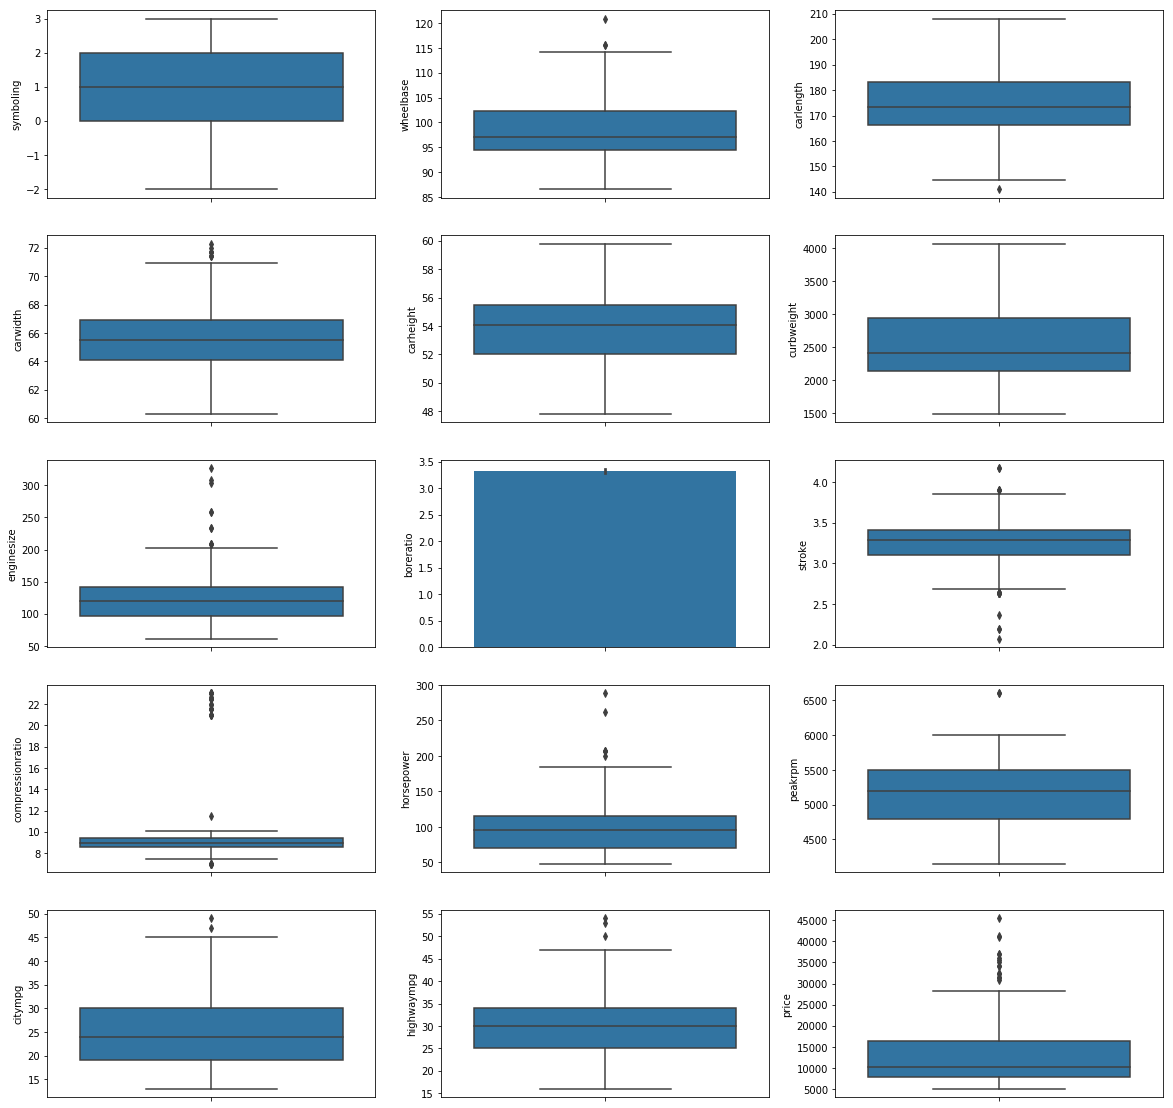

In [10]:
plt.figure(figsize=(20,20))
plt.subplot(5,3,1)
sns.boxplot(y='symboling', data = car_price_df)
plt.subplot(5,3,2)
sns.boxplot(y='wheelbase', data = car_price_df)
plt.subplot(5,3,3)
sns.boxplot(y='carlength', data = car_price_df)
plt.subplot(5,3,4)
sns.boxplot(y='carwidth', data = car_price_df)
plt.subplot(5,3,5)
sns.boxplot(y='carheight', data = car_price_df)
plt.subplot(5,3,6)
sns.boxplot(y='curbweight', data = car_price_df)
plt.subplot(5,3,7)
sns.boxplot(y='enginesize', data = car_price_df)
plt.subplot(5,3,8)
sns.barplot(y='boreratio', data = car_price_df)
plt.subplot(5,3,9)
sns.boxplot(y='stroke', data = car_price_df)
plt.subplot(5,3,10)
sns.boxplot(y='compressionratio', data = car_price_df)
plt.subplot(5,3,11)
sns.boxplot(y='horsepower', data = car_price_df)
plt.subplot(5,3,12)
sns.boxplot(y='peakrpm', data = car_price_df)
plt.subplot(5,3,13)
sns.boxplot(y='citympg', data = car_price_df)
plt.subplot(5,3,14)
sns.boxplot(y='highwaympg', data = car_price_df)
plt.subplot(5,3,15)
sns.boxplot(y='price', data = car_price_df)
plt.show()

#### 1) wheelbase - Wheelbase of car

##### Analysis

In [11]:
outlier_assessment(car_price_df, 'wheelbase')

,wheelbase,range,pct_change
0.00,86.600,0.00,NaN
0.01,88.408,0.01,2.088
0.02,88.672,0.02,0.299
0.03,89.500,0.03,0.934
0.04,91.300,0.04,2.011
0.05,93.020,0.05,1.884
0.06,93.100,0.06,0.086
0.94,109.784,0.94,0.627
0.95,110.000,0.95,0.197
0.96,112.840,0.96,2.582


##### Inference - No outlier removal seems to be required for this

#### 2) carlength - Length of car

##### Analysis

In [12]:
outlier_assessment(car_price_df, 'carlength')

,carlength,range,pct_change
0.00,141.100,0.00,NaN
0.01,144.816,0.01,2.634
0.02,150.000,0.02,3.580
0.03,155.900,0.03,3.933
0.04,156.060,0.04,0.103
0.05,157.140,0.05,0.692
0.06,157.300,0.06,0.102
0.94,192.700,0.94,0.146
0.95,196.360,0.95,1.899
0.96,198.900,0.96,1.294


##### Inference - No outlier removal seems to be required for this

#### 3) carwidth - Width of car

##### Analysis

In [13]:
outlier_assessment(car_price_df, 'carwidth')

,carwidth,range,pct_change
0.00,60.300,0.00,NaN
0.01,62.536,0.01,3.708
0.02,63.600,0.02,1.701
0.03,63.600,0.03,0.000
0.04,63.600,0.04,0.000
0.05,63.600,0.05,0.000
0.06,63.600,0.06,-0.000
0.94,70.300,0.94,1.006
0.95,70.460,0.95,0.228
0.96,70.852,0.96,0.556


##### Inference - No outlier removal seems to be required for this

#### 4) enginesize - Size of car

##### Analysis

In [14]:
outlier_assessment(car_price_df, 'enginesize')

,enginesize,range,pct_change
0.00,61.00,0.00,NaN
0.01,70.00,0.01,14.754
0.02,79.08,0.02,12.971
0.03,90.00,0.03,13.809
0.04,90.00,0.04,0.000
0.05,90.00,0.05,0.000
0.06,90.00,0.06,0.000
0.94,194.00,0.94,6.011
0.95,201.20,0.95,3.711
0.96,209.00,0.96,3.877


##### Inference - No outlier removal seems to be required for this

#### 5) stroke - Stroke or volume inside the engine

##### Analysis

In [15]:
outlier_assessment(car_price_df, 'stroke')

,stroke,range,pct_change
0.00,2.0700,0.00,NaN
0.01,2.1968,0.01,6.126
0.02,2.6400,0.02,20.175
0.03,2.6400,0.03,0.000
0.04,2.6400,0.04,0.000
0.05,2.6400,0.05,0.000
0.06,2.6400,0.06,0.000
0.94,3.6400,0.94,1.676
0.95,3.6400,0.95,0.000
0.96,3.8248,0.96,5.077


##### Inference - No outlier removal seems to be required for this

#### 6) compressionratio - compression ratio of car

##### Analysis

In [16]:
outlier_assessment(car_price_df, 'compressionratio')

,compressionratio,range,pct_change
0.00,7.000,0.00,NaN
0.01,7.000,0.01,0.000
0.02,7.000,0.02,0.000
0.03,7.060,0.03,0.857
0.04,7.500,0.04,6.232
0.05,7.500,0.05,0.000
0.06,7.600,0.06,1.333
0.94,21.500,0.94,0.655
0.95,21.820,0.95,1.488
0.96,22.420,0.96,2.750


##### Inference - No outlier removal seems to be required for this

#### 7) horsepower - Horsepower

##### Analysis

In [17]:
outlier_assessment(car_price_df, 'horsepower')

,horsepower,range,pct_change
0.00,48.00,0.00,NaN
0.01,52.12,0.01,8.583
0.02,56.00,0.02,7.444
0.03,58.24,0.03,4.000
0.04,62.00,0.04,6.456
0.05,62.00,0.05,0.000
0.06,62.00,0.06,0.000
0.94,175.76,0.94,8.494
0.95,180.80,0.95,2.868
0.96,182.00,0.96,0.664


##### Inference - No outlier removal seems to be required for this

#### 8) peakrpm - car peak rpm

##### Analysis

In [18]:
outlier_assessment(car_price_df, 'peakrpm')

,peakrpm,range,pct_change
0.00,4150.0,0.00,NaN
0.01,4150.0,0.01,0.000
0.02,4154.0,0.02,0.096
0.03,4200.0,0.03,1.107
0.04,4200.0,0.04,0.000
0.05,4250.0,0.05,1.190
0.06,4274.0,0.06,0.565
0.94,5900.0,0.94,1.724
0.95,5980.0,0.95,1.356
0.96,6000.0,0.96,0.334


##### Inference - No outlier removal seems to be required for this

#### 9) citympg - Mileage in city

##### Analysis

In [19]:
outlier_assessment(car_price_df, 'citympg')

,citympg,range,pct_change
0.00,13.00,0.00,NaN
0.01,14.04,0.01,8.000
0.02,15.00,0.02,6.838
0.03,16.00,0.03,6.667
0.04,16.00,0.04,0.000
0.05,16.00,0.05,0.000
0.06,17.00,0.06,6.250
0.94,37.00,0.94,0.000
0.95,37.00,0.95,0.000
0.96,38.00,0.96,2.703


##### Inference - No outlier removal seems to be required for this

#### 10) highwaympg	- Mileage on highway

##### Analysis

In [20]:
outlier_assessment(car_price_df, 'highwaympg')

,highwaympg,range,pct_change
0.00,16.00,0.00,NaN
0.01,17.04,0.01,6.500
0.02,18.08,0.02,6.103
0.03,19.12,0.03,5.752
0.04,20.32,0.04,6.276
0.05,22.00,0.05,8.268
0.06,22.00,0.06,0.000
0.94,42.00,0.94,2.439
0.95,42.80,0.95,1.905
0.96,43.00,0.96,0.467


##### Inference - No outlier removal seems to be required for this

#### 11) price - Price of car

##### Analysis

In [21]:
outlier_assessment(car_price_df, 'price')

,price,range,pct_change
0.00,5118.00,0.00,NaN
0.01,5201.12,0.01,1.624
0.02,5389.80,0.02,3.628
0.03,5507.76,0.03,2.189
0.04,5655.68,0.04,2.686
0.05,6197.00,0.05,9.571
0.06,6244.84,0.06,0.772
0.94,31552.12,0.94,4.976
0.95,32472.40,0.95,2.917
0.96,34159.04,0.96,5.194


##### Inference - No outlier removal seems to be required for this

#### Inference : 

In [22]:
final_rows_count = len(car_price_df.index)
print('Remaining number of rows : {:}'.format(final_rows_count))
print('Number of rows removed : {:}'.format(initial_rows_count - final_rows_count))

Remaining number of rows : 205
Number of rows removed : 0


### Standarising Text

#### Describing Categorical Data

In [23]:
categorical_data.describe()

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
count,205,205,205,205,205,205,205,205,205,205
unique,147,2,2,2,5,3,2,7,7,8
top,toyota corolla,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,6,185,168,115,96,120,202,148,159,94


#### 1) carcompany - Name of car company

##### Based on given instructions, deriving carcompany column from CarName column

In [24]:
car_price_df['carcompany'] = car_price_df['CarName'].apply(lambda x: x.split(' ')[0])
car_price_df = car_price_df.drop('CarName', axis = 1)

##### Analysis

In [25]:
car_price_df['carcompany'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

##### Correction

In [26]:
car_price_df.loc[:,'carcompany'] = car_price_df.loc[:,'carcompany'].str.lower().str.strip()

car_price_df.loc[:,'carcompany'] = car_price_df.loc[:,'carcompany'].str.replace('maxda', 'porsche', regex=False)
car_price_df.loc[:,'carcompany'] = car_price_df.loc[:,'carcompany'].str.replace('porcshce', 'mazda', regex=False)
car_price_df.loc[:,'carcompany'] = car_price_df.loc[:,'carcompany'].str.replace('toyouta', 'toyota', regex=False)
car_price_df.loc[:,'carcompany'] = car_price_df.loc[:,'carcompany'].str.replace('vokswagen', 'volkswagen', regex=False)
car_price_df.loc[:,'carcompany'] = car_price_df.loc[:,'carcompany'].str.replace('vw', 'volkswagen', regex=False)

car_price_df['carcompany'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'porsche', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

#### 2) cylindernumber - cylinder placed in the car

##### Analysis

In [27]:
car_price_df['cylindernumber'].unique()

array(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'],
      dtype=object)

##### Correction

In [28]:
car_price_df['cylindernumber'] = car_price_df['cylindernumber'].map({'two': 2, 'three': 3, 'four': 4,  'five': 5,\
                                                                     'six': 6,  'eight': 8, 'twelve':12})

#### 3) doornumber - Number of doors in a car

##### Analysis

In [29]:
car_price_df['doornumber'].unique()

array(['two', 'four'], dtype=object)

##### Correction

In [30]:
car_price_df['doornumber'] = car_price_df['doornumber'].map({'two': 2, 'four': 4})

### Revaluating Numerical and Categorical Data

In [31]:
numeric_data = car_price_df.select_dtypes(include={np.number})
categorical_data = car_price_df.select_dtypes(exclude={np.number})

#### Describing Numerical Data

In [32]:
numeric_data.describe()

,car_ID,symboling,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,3.121951,98.756585,174.049268,65.907805,53.724878,2555.565854,4.380488,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,0.994966,6.021776,12.337289,2.145204,2.443522,520.680204,1.080854,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,2.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,2.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,4.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,4.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,4.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,4.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,4.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,4.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,12.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


#### Describing Categorical Data

In [33]:
categorical_data.describe()

,fueltype,aspiration,carbody,drivewheel,enginelocation,enginetype,fuelsystem,carcompany
count,205,205,205,205,205,205,205,205
unique,2,2,5,3,2,7,8,22
top,gas,std,sedan,fwd,front,ohc,mpfi,toyota
freq,185,168,96,120,202,148,94,32


## Step 3 - Visualising Data

### Evaluating corelation between numerical data

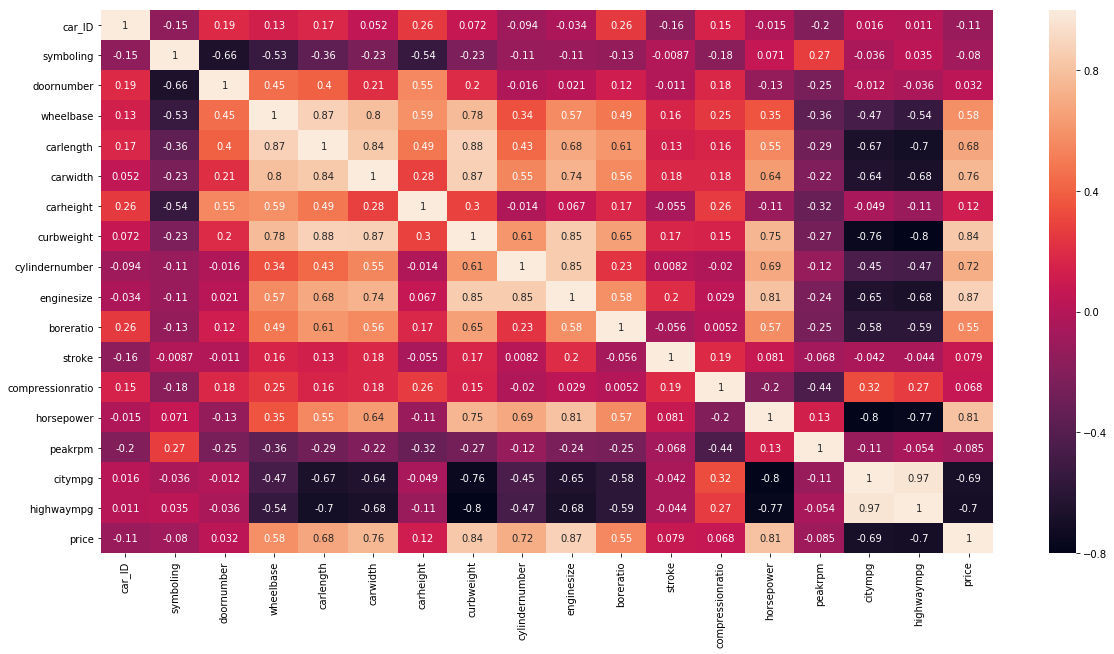

In [34]:
plt.figure(figsize=(20,10))
sns.heatmap(numeric_data.corr(), annot=True)
plt.show()

### Pair-plots between numerical data

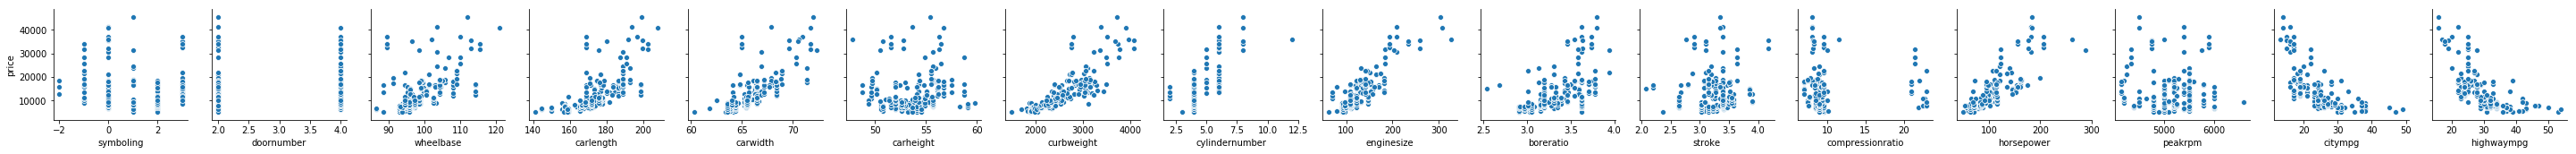

In [35]:
x_vars = list(numeric_data.columns)
x_vars.remove('price')
x_vars.remove('car_ID')
sns.pairplot(y_vars='price', x_vars=x_vars, data = numeric_data)
plt.show()

### Segmented Analysis of Categorical Variables against Price

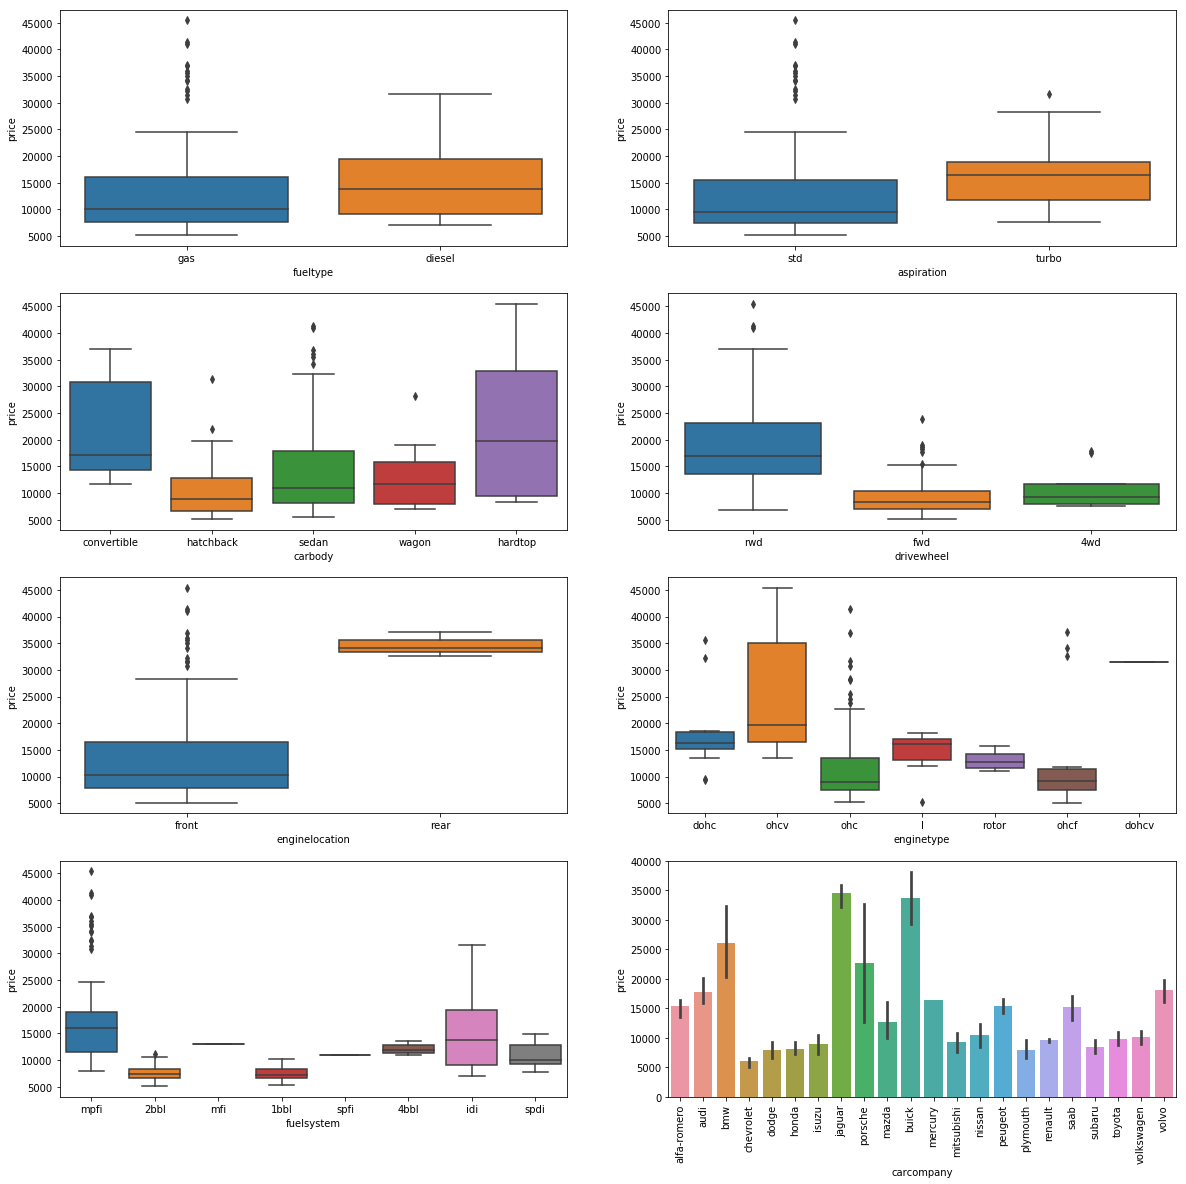

In [36]:
plt.figure(figsize=(20,20))
plt.subplot(4,2,1)
sns.boxplot(y='price',x='fueltype', data = car_price_df)
plt.subplot(4,2,2)
sns.boxplot(y='price',x='aspiration', data = car_price_df)
plt.subplot(4,2,3)
sns.boxplot(y='price',x='carbody', data = car_price_df)
plt.subplot(4,2,4)
sns.boxplot(y='price',x='drivewheel', data = car_price_df)
plt.subplot(4,2,5)
sns.boxplot(y='price',x='enginelocation', data = car_price_df)
plt.subplot(4,2,6)
sns.boxplot(y='price',x='enginetype', data = car_price_df)
plt.subplot(4,2,7)
sns.boxplot(y='price',x='fuelsystem', data = car_price_df)
plt.subplot(4,2,8)
company_name_plt = sns.barplot(y='price',x='carcompany', data = car_price_df)
for label in company_name_plt.get_xticklabels():
    label.set_rotation(90)
plt.show()

## Step 4 - Data Preparation

### Encoding Categorical Data to Numerical Data

#### Creating Dummy variables to convert categorical data to numerical data

In [37]:
converted_categorical_data = pd.get_dummies(categorical_data, drop_first = True)
display(converted_categorical_data.describe())

,fueltype_gas,aspiration_turbo,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginelocation_rear,enginetype_dohcv,...,carcompany_nissan,carcompany_peugeot,carcompany_plymouth,carcompany_porsche,carcompany_renault,carcompany_saab,carcompany_subaru,carcompany_toyota,carcompany_volkswagen,carcompany_volvo
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.902439,0.180488,0.039024,0.341463,0.468293,0.121951,0.585366,0.370732,0.014634,0.004878,...,0.087805,0.053659,0.034146,0.029268,0.009756,0.029268,0.058537,0.156098,0.058537,0.053659
std,0.297446,0.385535,0.194127,0.475361,0.500215,0.328031,0.493865,0.484183,0.120377,0.069843,...,0.283704,0.225894,0.182050,0.168970,0.098531,0.168970,0.235330,0.363836,0.235330,0.225894
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dropping redundant categorical variables

In [38]:
car_price_df = car_price_df.drop(categorical_data.columns, axis = 1)

#### Concatenating converted categorical variables to car pricing data

In [39]:
encoded_car_price_df = pd.concat([car_price_df, converted_categorical_data], axis = 1)
encoded_car_price_df.describe()

,car_ID,symboling,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,...,carcompany_nissan,carcompany_peugeot,carcompany_plymouth,carcompany_porsche,carcompany_renault,carcompany_saab,carcompany_subaru,carcompany_toyota,carcompany_volkswagen,carcompany_volvo
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,3.121951,98.756585,174.049268,65.907805,53.724878,2555.565854,4.380488,126.907317,...,0.087805,0.053659,0.034146,0.029268,0.009756,0.029268,0.058537,0.156098,0.058537,0.053659
std,59.322565,1.245307,0.994966,6.021776,12.337289,2.145204,2.443522,520.680204,1.080854,41.642693,...,0.283704,0.225894,0.182050,0.168970,0.098531,0.168970,0.235330,0.363836,0.235330,0.225894
min,1.000000,-2.000000,2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,2.000000,61.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.000000,0.000000,2.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,4.000000,97.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,103.000000,1.000000,4.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,4.000000,120.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,154.000000,2.000000,4.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,4.000000,141.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,205.000000,3.000000,4.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,12.000000,326.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Splitting data into Training and Testing Sets

In [40]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
train_df, test_df = train_test_split(encoded_car_price_df, train_size=0.7, test_size=0.3, random_state=100)

### Describing Train Data

In [41]:
print('Total number of rows in training data : {:}'.format(len(train_df.index)))
display(train_df.describe())

Total number of rows in training data : 143


,car_ID,symboling,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,...,carcompany_nissan,carcompany_peugeot,carcompany_plymouth,carcompany_porsche,carcompany_renault,carcompany_saab,carcompany_subaru,carcompany_toyota,carcompany_volkswagen,carcompany_volvo
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,98.524476,0.797203,3.118881,98.523077,173.416783,65.839860,53.551748,2539.510490,4.405594,124.958042,...,0.097902,0.055944,0.027972,0.034965,0.013986,0.020979,0.076923,0.139860,0.048951,0.041958
std,58.977655,1.195999,0.996399,5.961835,12.598122,2.214203,2.433766,544.650539,1.158178,40.974034,...,0.298227,0.230621,0.165472,0.184337,0.117845,0.143818,0.267406,0.348061,0.216524,0.201198
min,1.000000,-2.000000,2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,2.000000,61.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.500000,0.000000,2.000000,94.500000,165.650000,63.950000,51.800000,2121.000000,4.000000,97.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,97.000000,1.000000,4.000000,96.500000,172.000000,65.400000,53.700000,2405.000000,4.000000,110.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,147.500000,1.000000,4.000000,101.200000,182.300000,66.900000,55.350000,2930.500000,4.000000,141.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,205.000000,3.000000,4.000000,115.600000,202.600000,72.300000,59.100000,4066.000000,12.000000,326.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Describing Test Data

In [42]:
print('Total number of rows in testing data : {:}'.format(len(test_df.index)))
display(test_df.describe())

Total number of rows in testing data : 62


,car_ID,symboling,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,...,carcompany_nissan,carcompany_peugeot,carcompany_plymouth,carcompany_porsche,carcompany_renault,carcompany_saab,carcompany_subaru,carcompany_toyota,carcompany_volkswagen,carcompany_volvo
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,...,62.000000,62.000000,62.000000,62.000000,62.0,62.000000,62.000000,62.000000,62.000000,62.000000
mean,113.322581,0.919355,3.129032,99.295161,175.508065,66.064516,54.124194,2592.596774,4.322581,131.403226,...,0.064516,0.048387,0.048387,0.016129,0.0,0.048387,0.016129,0.193548,0.080645,0.080645
std,59.300782,1.358620,0.999736,6.172983,11.681726,1.985282,2.438670,462.719100,0.882883,43.147273,...,0.247676,0.216335,0.216335,0.127000,0.0,0.216335,0.127000,0.398304,0.274512,0.274512
min,4.000000,-2.000000,2.000000,86.600000,144.600000,62.500000,49.400000,1819.000000,4.000000,79.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.000000,0.000000,2.000000,95.700000,169.350000,64.600000,52.150000,2275.000000,4.000000,108.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,117.500000,1.000000,4.000000,97.850000,174.800000,65.600000,54.450000,2535.000000,4.000000,121.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,167.500000,2.000000,4.000000,103.150000,185.375000,66.500000,55.700000,2944.250000,4.000000,144.750000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,202.000000,3.000000,4.000000,120.900000,208.100000,72.000000,59.800000,3900.000000,8.000000,308.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


### Rescaling Training Data

In [43]:
scalar = MinMaxScaler()
num_columns = list(numeric_data.columns)
train_df[num_columns] = scalar.fit_transform(train_df[num_columns])
train_df.describe()

,car_ID,symboling,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,...,carcompany_nissan,carcompany_peugeot,carcompany_plymouth,carcompany_porsche,carcompany_renault,carcompany_saab,carcompany_subaru,carcompany_toyota,carcompany_volkswagen,carcompany_volvo
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.478061,0.559441,0.559441,0.411141,0.525476,0.461655,0.509004,0.407878,0.240559,0.241351,...,0.097902,0.055944,0.027972,0.034965,0.013986,0.020979,0.076923,0.139860,0.048951,0.041958
std,0.289106,0.239200,0.498199,0.205581,0.204848,0.184517,0.215378,0.211269,0.115818,0.154619,...,0.298227,0.230621,0.165472,0.184337,0.117845,0.143818,0.267406,0.348061,0.216524,0.201198
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.232843,0.400000,0.000000,0.272414,0.399187,0.304167,0.353982,0.245539,0.200000,0.135849,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.470588,0.600000,1.000000,0.341379,0.502439,0.425000,0.522124,0.355702,0.200000,0.184906,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.718137,0.600000,1.000000,0.503448,0.669919,0.550000,0.668142,0.559542,0.200000,0.301887,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Dividing Training data into X and Y sets for model building

In [44]:
y_train = train_df.pop('price')
X_train = generate_x(train_df)

## Step 5 - Building Model

### Coarse Feature Selection using RFE

#### Running RFE

#### Instead of using arbitray number in RFE for feature selection, using all possible features to start with

In [45]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm)           
rfe = rfe.fit(X_train, y_train)

#### RFE Results

In [46]:
rfe_result = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
display(rfe_result)

[('car_ID', True, 1),
 ('symboling', False, 28),
 ('doornumber', False, 27),
 ('wheelbase', False, 12),
 ('carlength', True, 1),
 ('carwidth', True, 1),
 ('carheight', False, 10),
 ('curbweight', True, 1),
 ('cylindernumber', True, 1),
 ('enginesize', True, 1),
 ('boreratio', True, 1),
 ('stroke', True, 1),
 ('compressionratio', True, 1),
 ('horsepower', False, 7),
 ('peakrpm', True, 1),
 ('citympg', False, 18),
 ('highwaympg', False, 5),
 ('fueltype_gas', True, 1),
 ('aspiration_turbo', False, 8),
 ('carbody_hardtop', False, 13),
 ('carbody_hatchback', False, 11),
 ('carbody_sedan', False, 14),
 ('carbody_wagon', False, 15),
 ('drivewheel_fwd', False, 25),
 ('drivewheel_rwd', False, 22),
 ('enginelocation_rear', True, 1),
 ('enginetype_dohcv', True, 1),
 ('enginetype_l', False, 9),
 ('enginetype_ohc', False, 16),
 ('enginetype_ohcf', False, 20),
 ('enginetype_ohcv', False, 24),
 ('enginetype_rotor', False, 4),
 ('fuelsystem_2bbl', False, 21),
 ('fuelsystem_4bbl', False, 17),
 ('fuelsy

#### Selecting features

In [47]:
rfe_selected_columns = [x[0] for x in rfe_result if x[1] == True]
print('Total features selected after RFE: {:} \n'.format(len(rfe_selected_columns)))
print('Following features selected : {:}'.format(rfe_selected_columns))

Total features selected after RFE: 30 

Following features selected : ['car_ID', 'carlength', 'carwidth', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'peakrpm', 'fueltype_gas', 'enginelocation_rear', 'enginetype_dohcv', 'fuelsystem_idi', 'carcompany_bmw', 'carcompany_dodge', 'carcompany_honda', 'carcompany_isuzu', 'carcompany_mazda', 'carcompany_mitsubishi', 'carcompany_nissan', 'carcompany_peugeot', 'carcompany_plymouth', 'carcompany_porsche', 'carcompany_renault', 'carcompany_saab', 'carcompany_subaru', 'carcompany_toyota', 'carcompany_volkswagen', 'carcompany_volvo']


### Manually Feature Selection and Model Building

#### Algorithm used to eliminate features - 
> 1. Build a model containing all variables selected after RFE
2. Check VIF and summary
3. Remove variables with high VIF (>3 generally and >10 definitely) and which are insignificant (p>0.03 - selected after some experimentation with 0.05 value), one by one
4. If the model has variables which have a high VIF and are significant, check and remove other insignificant variables
5. After removing the insignificant variables, the VIFs should decline
6. If some variables still have a high VIF, remove the variable which is relatively less significant
7. Now, variables must be significant. If the number of variables is still high, remove them in order of insignificance until you arrive at a limited number of variables that explain the model well.

#### Evaluating model : First Model - Using all selected features from RFE

In [48]:
X_train1 = generate_x(train_df, rfe_selected_columns)
print('Length of X columns : {:}'.format(len(X_train1.columns)))
lr_model1 = generate_linear_regression_model(y_train, X_train1)

Length of X columns : 30
R Squared : 0.9570474729271096
R Squared Adjusted: 0.9460242580145979
F-Statistic : 86.82108445883875
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 25
Feature Significance Analysis :


,Features,VIF,p_value
0,fueltype_gas,265.63,0.580
1,carcompany_isuzu,1.78,0.067
2,compressionratio,66.89,0.053
3,fuelsystem_idi,149.85,0.010
4,carlength,9.91,0.007
5,carcompany_saab,5.25,0.002
6,curbweight,18.89,0.002
7,stroke,7.03,0.000
8,carcompany_porsche,3.75,0.000
9,carcompany_mazda,3.75,0.000


#### Re-evaluating model : Iteratively - After eliminating feature based on p - value and VIF as defined in above mentioned algorithm

##### Second Model :

In [49]:
X_train2, lr_model2 = update_linear_model(X_train1, 'fueltype_gas')

Length of X columns : 29
R Squared : 0.9570474729271096
R Squared Adjusted: 0.9460242580145979
F-Statistic : 86.82108445883884
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 25
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_isuzu,1.81,0.067
1,compressionratio,89.72,0.053
2,fuelsystem_idi,67.52,0.030
3,carlength,75.05,0.007
4,carcompany_saab,5.35,0.002
5,curbweight,77.53,0.002
6,peakrpm,13.24,0.001
7,stroke,27.77,0.000
8,carcompany_porsche,3.86,0.000
9,carcompany_mazda,4.05,0.000


##### Third Model :

In [50]:
X_train3, lr_model3 = update_linear_model(X_train2, 'compressionratio')

Length of X columns : 28
R Squared : 0.9555969936883696
R Squared Adjusted: 0.9446909921381446
F-Statistic : 87.6212046447632
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 24
Feature Significance Analysis :


,Features,VIF,p_value
0,fuelsystem_idi,2.23,0.114
1,carcompany_isuzu,1.81,0.076
2,carcompany_saab,5.33,0.003
3,peakrpm,12.47,0.002
4,carlength,73.34,0.002
5,stroke,27.58,0.002
6,carcompany_porsche,3.86,0.000
7,carcompany_volvo,19.00,0.000
8,boreratio,47.13,0.000
9,carcompany_mazda,4.04,0.000


##### Fourth Model :

In [51]:
X_train4, lr_model4 = update_linear_model(X_train3, 'fuelsystem_idi')

Length of X columns : 27
R Squared : 0.9546115182795325
R Squared Adjusted: 0.9439550921364662
F-Statistic : 89.58083183456968
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 23
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_isuzu,1.79,0.056
1,peakrpm,9.27,0.009
2,stroke,24.25,0.006
3,carcompany_saab,5.21,0.002
4,carlength,72.14,0.001
5,boreratio,47.08,0.000
6,carcompany_porsche,3.77,0.000
7,cylindernumber,44.31,0.000
8,carcompany_volvo,18.62,0.000
9,carcompany_mazda,4.01,0.000


##### Fifth Model :

In [52]:
X_train5, lr_model5 = update_linear_model(X_train4, 'carcompany_isuzu')

Length of X columns : 26
R Squared : 0.953134831448566
R Squared Adjusted: 0.9426305695318653
F-Statistic : 90.73791562005687
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 20
Feature Significance Analysis :


,Features,VIF,p_value
0,const,NaN,0.031
1,peakrpm,9.09,0.018
2,carcompany_saab,3.96,0.011
3,stroke,22.18,0.003
4,carcompany_porsche,3.06,0.001
5,carlength,71.19,0.001
6,carcompany_volvo,14.00,0.001
7,car_ID,149.42,0.000
8,boreratio,46.40,0.000
9,cylindernumber,41.12,0.000


Inference - No feature left with High p-value, identifying features with High VIF

In [53]:
feature_significance_analysis(lr_model5, X_train5, 'VIF')

Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 20
Feature Significance Analysis :


,Features,VIF,p_value
0,car_ID,149.42,0.000
1,enginesize,77.39,0.000
2,carlength,71.19,0.001
3,curbweight,69.57,0.000
4,carwidth,56.45,0.000
5,boreratio,46.40,0.000
6,cylindernumber,41.12,0.000
7,carcompany_toyota,33.22,0.000
8,stroke,22.18,0.003
9,carcompany_volkswagen,17.01,0.000


##### Sixth Model :

In [54]:
X_train6, lr_model6 = update_linear_model(X_train5, 'car_ID')

Length of X columns : 25
R Squared : 0.9472627305927527
R Squared Adjusted: 0.9359940832835119
F-Statistic : 84.06179593676231
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 16
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_volvo,1.85,0.954
1,carcompany_saab,1.55,0.588
2,carcompany_porsche,2.22,0.136
3,const,NaN,0.100
4,carcompany_mazda,2.03,0.100
5,peakrpm,8.78,0.079
6,carcompany_subaru,4.57,0.066
7,carcompany_volkswagen,1.55,0.059
8,carcompany_plymouth,1.38,0.035
9,stroke,22.16,0.014


##### Seventh Model :

In [55]:
X_train7, lr_model7 = update_linear_model(X_train6, 'peakrpm')

Length of X columns : 24
R Squared : 0.9458454048645846
R Squared Adjusted: 0.9348309109387374
F-Statistic : 85.87279735522056
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 15
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_volvo,1.83,0.929
1,carcompany_saab,1.55,0.603
2,carcompany_porsche,2.22,0.134
3,carcompany_mazda,2.03,0.103
4,carcompany_volkswagen,1.54,0.092
5,carcompany_plymouth,1.33,0.069
6,carcompany_renault,1.31,0.038
7,carcompany_subaru,4.09,0.016
8,boreratio,33.63,0.011
9,stroke,22.16,0.003


##### Eighth Model :

In [56]:
X_train8, lr_model8 = update_linear_model(X_train7, 'carcompany_volvo')

Length of X columns : 23
R Squared : 0.9458417931185215
R Squared Adjusted: 0.9353742405279836
F-Statistic : 90.35940206056522
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 14
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_saab,1.32,0.540
1,carcompany_porsche,2.13,0.129
2,carcompany_mazda,1.75,0.086
3,carcompany_volkswagen,1.46,0.085
4,carcompany_plymouth,1.31,0.067
5,carcompany_renault,1.28,0.034
6,carcompany_subaru,3.03,0.005
7,boreratio,27.07,0.004
8,stroke,21.15,0.003
9,cylindernumber,28.73,0.001


##### Ninth Model :

In [57]:
X_train9, lr_model9 = update_linear_model(X_train8, 'carcompany_saab')

Length of X columns : 22
R Squared : 0.9456702120876637
R Squared Adjusted: 0.935709750970402
F-Statistic : 94.9424129018283
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 11
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_porsche,2.12,0.116
1,carcompany_volkswagen,1.43,0.067
2,carcompany_plymouth,1.30,0.060
3,carcompany_mazda,1.67,0.060
4,boreratio,25.36,0.004
5,stroke,21.01,0.003
6,cylindernumber,28.33,0.001
7,carlength,64.13,0.000
8,enginesize,46.55,0.000
9,curbweight,65.93,0.000


##### Tenth Model :

In [58]:
X_train10, lr_model10 = update_linear_model(X_train9, 'carcompany_porsche')

Length of X columns : 21
R Squared : 0.9445334900643444
R Squared Adjusted: 0.9349070709846025
F-Statistic : 98.1188832773808
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 13
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_mazda,1.59,0.117
1,carcompany_volkswagen,1.39,0.108
2,carcompany_plymouth,1.28,0.093
3,carcompany_renault,1.25,0.042
4,enginetype_dohcv,1.51,0.042
5,carcompany_dodge,1.49,0.034
6,stroke,20.57,0.003
7,boreratio,23.26,0.002
8,carlength,60.71,0.001
9,cylindernumber,27.50,0.001


##### Eleventh Model :

In [59]:
X_train11, lr_model11 = update_linear_model(X_train10, 'carcompany_mazda')

Length of X columns : 20
R Squared : 0.9433924417176182
R Squared Adjusted: 0.9341125141303425
F-Statistic : 101.65946154700192
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 14
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_volkswagen,1.28,0.223
1,carcompany_plymouth,1.23,0.168
2,carcompany_renault,1.18,0.077
3,carcompany_dodge,1.41,0.073
4,carcompany_nissan,1.65,0.054
5,enginetype_dohcv,1.51,0.046
6,const,NaN,0.040
7,boreratio,22.79,0.003
8,stroke,18.58,0.002
9,cylindernumber,27.50,0.001


##### Twelvth Model :

In [60]:
X_train12, lr_model12 = update_linear_model(X_train11, 'carcompany_volkswagen')

Length of X columns : 19
R Squared : 0.9426948436978926
R Squared Adjusted: 0.9338428276837459
F-Statistic : 106.49493202354616
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 14
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_plymouth,1.19,0.240
1,carcompany_dodge,1.35,0.114
2,carcompany_renault,1.16,0.112
3,carcompany_nissan,1.54,0.095
4,carcompany_honda,1.59,0.051
5,enginetype_dohcv,1.51,0.043
6,const,NaN,0.032
7,boreratio,22.64,0.003
8,stroke,16.89,0.001
9,cylindernumber,27.10,0.001


##### Thirteenth Model :

In [61]:
X_train13, lr_model13 = update_linear_model(X_train12, 'carcompany_plymouth')

Length of X columns : 18
R Squared : 0.9420443506594267
R Squared Adjusted: 0.9336314338196661
F-Statistic : 111.97594943613265
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 13
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_dodge,1.30,0.168
1,carcompany_nissan,1.48,0.141
2,carcompany_renault,1.15,0.128
3,carcompany_honda,1.51,0.081
4,enginetype_dohcv,1.51,0.048
5,const,NaN,0.041
6,boreratio,22.63,0.004
7,cylindernumber,25.98,0.001
8,stroke,15.58,0.000
9,carlength,60.26,0.000


##### Fourteenth Model :

In [62]:
X_train14, lr_model14 = update_linear_model(X_train13, 'carcompany_dodge')

Length of X columns : 17
R Squared : 0.9411436458645143
R Squared Adjusted: 0.9331391817020882
F-Statistic : 117.57734518724668
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 12
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_nissan,1.43,0.218
1,carcompany_renault,1.14,0.155
2,carcompany_honda,1.41,0.151
3,const,NaN,0.046
4,enginetype_dohcv,1.50,0.041
5,boreratio,22.58,0.004
6,carlength,58.13,0.001
7,cylindernumber,24.45,0.000
8,stroke,14.00,0.000
9,enginesize,42.26,0.000


##### Fifteenth Model :

In [63]:
X_train15, lr_model15 = update_linear_model(X_train14, 'carcompany_nissan')

Length of X columns : 16
R Squared : 0.9404234037519162
R Squared Adjusted: 0.9328581216886676
F-Statistic : 124.30777806955611
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 10
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_honda,1.36,0.218
1,carcompany_renault,1.12,0.217
2,enginetype_dohcv,1.50,0.032
3,boreratio,22.19,0.002
4,carlength,56.91,0.000
5,cylindernumber,23.49,0.000
6,stroke,13.44,0.000
7,enginesize,42.26,0.000
8,curbweight,63.13,0.000
9,carwidth,48.08,0.000


##### Sixteenth Model :

In [64]:
X_train16, lr_model16 = update_linear_model(X_train15, 'carcompany_honda')

Length of X columns : 15
R Squared : 0.9397001699156643
R Squared Adjusted: 0.932578142740349
F-Statistic : 131.9427947667259
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 8
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_renault,1.11,0.268
1,boreratio,21.97,0.002
2,carlength,55.02,0.001
3,cylindernumber,23.46,0.000
4,stroke,11.43,0.000
5,enginesize,42.24,0.000
6,curbweight,63.11,0.000
7,carwidth,47.39,0.000


##### Seventeenth Model :

In [65]:
X_train17, lr_model17 = update_linear_model(X_train16, 'carcompany_renault')

Length of X columns : 14
R Squared : 0.9391130306717927
R Squared Adjusted: 0.9324535184015201
F-Statistic : 141.01828971227957
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 7
Feature Significance Analysis :


,Features,VIF,p_value
0,carlength,54.63,0.001
1,boreratio,21.97,0.000
2,cylindernumber,22.82,0.000
3,enginesize,41.12,0.000
4,stroke,11.03,0.000
5,curbweight,61.88,0.000
6,carwidth,47.37,0.000


Inference - No feature left with High p-value, identifying features with High VIF

In [66]:
feature_significance_analysis(lr_model17, X_train17, 'VIF')

Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 7
Feature Significance Analysis :


,Features,VIF,p_value
0,curbweight,61.88,0.000
1,carlength,54.63,0.001
2,carwidth,47.37,0.000
3,enginesize,41.12,0.000
4,cylindernumber,22.82,0.000
5,boreratio,21.97,0.000
6,stroke,11.03,0.000


##### Eighteenth Model :

In [67]:
X_train18, lr_model18 = update_linear_model(X_train17, 'curbweight')

Length of X columns : 13
R Squared : 0.9234765489132736
R Squared Adjusted: 0.9157648832998826
F-Statistic : 119.75059542385877
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 7
Feature Significance Analysis :


,Features,VIF,p_value
0,carlength,42.55,0.449
1,carcompany_subaru,2.45,0.037
2,boreratio,21.78,0.000
3,cylindernumber,20.55,0.000
4,stroke,10.93,0.000
5,carwidth,42.96,0.000
6,enginesize,22.07,0.000


##### Nineteenth Model :

In [68]:
X_train19, lr_model19 = update_linear_model(X_train18, 'carlength')

Length of X columns : 12
R Squared : 0.9231351253351197
R Squared Adjusted: 0.9160399061352845
F-Statistic : 130.1066393208222
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 6
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_subaru,2.42,0.044
1,boreratio,18.87,0.000
2,cylindernumber,20.43,0.000
3,stroke,10.89,0.000
4,enginesize,22.07,0.000
5,carwidth,24.50,0.000


##### Twentieth Model :

In [69]:
X_train20, lr_model20 = update_linear_model(X_train19, 'carcompany_subaru')

Length of X columns : 11
R Squared : 0.9206853364719586
R Squared Adjusted: 0.9140253265573902
F-Statistic : 138.24083571677818
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 6
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_toyota,1.23,0.039
1,stroke,8.17,0.000
2,boreratio,9.64,0.000
3,cylindernumber,16.93,0.000
4,enginesize,17.50,0.000
5,carwidth,24.26,0.000


##### Twenty-first Model :

In [70]:
X_train21, lr_model21 = update_linear_model(X_train20, 'carcompany_toyota')

Length of X columns : 10
R Squared : 0.9180451086324736
R Squared Adjusted: 0.9118364047409943
F-Statistic : 147.86421202859813
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 5
Feature Significance Analysis :


,Features,VIF,p_value
0,stroke,7.97,0.0
1,boreratio,9.54,0.0
2,cylindernumber,16.45,0.0
3,enginesize,17.38,0.0
4,carwidth,23.89,0.0


Inference - No feature left with High p-value, identifying features with High VIF

In [71]:
feature_significance_analysis(lr_model21, X_train21, 'VIF')

Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 5
Feature Significance Analysis :


,Features,VIF,p_value
0,carwidth,23.89,0.0
1,enginesize,17.38,0.0
2,cylindernumber,16.45,0.0
3,boreratio,9.54,0.0
4,stroke,7.97,0.0


##### Twenty-second Model :

##### carwidth, enginesize, cylindernumber causes significant drop in R2-adjusted value. Therefore, using boreratio

In [72]:
X_train22, lr_model22 = update_linear_model(X_train21, 'boreratio')

Length of X columns : 9
R Squared : 0.8912194008586152
R Squared Adjusted: 0.8838583076836343
F-Statistic : 121.07160983747835
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 5
Feature Significance Analysis :


,Features,VIF,p_value
0,enginetype_dohcv,1.13,0.291
1,stroke,7.84,0.149
2,cylindernumber,15.95,0.019
3,enginesize,16.91,0.000
4,carwidth,17.51,0.000


##### Twenty-third Model :

In [73]:
X_train23, lr_model23 = update_linear_model(X_train22, 'enginetype_dohcv')

Length of X columns : 8
R Squared : 0.8903019795687855
R Squared Adjusted: 0.8837528440206533
F-Statistic : 135.94190760377484
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 4
Feature Significance Analysis :


,Features,VIF,p_value
0,stroke,7.31,0.148
1,cylindernumber,15.50,0.032
2,enginesize,16.62,0.000
3,carwidth,16.94,0.000


##### Twenty-fourth Model :

In [74]:
X_train24, lr_model24 = update_linear_model(X_train23, 'stroke')

Length of X columns : 7
R Squared : 0.8885685596003327
R Squared Adjusted: 0.8827906330610906
F-Statistic : 153.78675266385468
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 3
Feature Significance Analysis :


,Features,VIF,p_value
0,cylindernumber,14.79,0.081
1,enginesize,15.83,0.000
2,carwidth,10.59,0.000


##### Twenty-fifth Model :

In [75]:
X_train25, lr_model25 = update_linear_model(X_train24, 'cylindernumber')

Length of X columns : 6
R Squared : 0.8860228128172388
R Squared Adjusted: 0.8809944075003523
F-Statistic : 176.20353909056888
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 2
Feature Significance Analysis :


,Features,VIF,p_value
0,enginesize,9.09,0.0
1,carwidth,9.07,0.0


##### Twenty-sixth Model :

##### enginesize causes significant drop in r2 adjusted. Therefore, enginesize seems significant

In [76]:
X_train26, lr_model26 = update_linear_model(X_train25, 'enginesize')

Length of X columns : 5
R Squared : 0.8196992333495141
R Squared Adjusted: 0.8131189133987664
F-Statistic : 124.5682944727299
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 1
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_mitsubishi,1.05,0.106


In [77]:
X_train26, lr_model26 = update_linear_model(X_train26, 'carcompany_mitsubishi')

Length of X columns : 4
R Squared : 0.8162104616362478
R Squared Adjusted: 0.810883228640197
F-Statistic : 153.2147105713839
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 0
Feature Significance Analysis :


,Features,VIF,p_value


Inference - Without enginesize, r2-adjusted equals 0.810883228640197 . Therefore, this model doesn't seem more optimised than 25th model

##### Twenty-seventh Model :

In [78]:
X_train27, lr_model27 = update_linear_model(X_train25, 'carwidth')

Length of X columns : 5
R Squared : 0.8052176065365861
R Squared Adjusted: 0.7981087600598192
F-Statistic : 113.2697982954325
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 2
Feature Significance Analysis :


,Features,VIF,p_value
0,carcompany_peugeot,1.07,0.545
1,carcompany_mitsubishi,1.04,0.031


In [79]:
X_train27, lr_model27 = update_linear_model(X_train27, 'carcompany_peugeot')

Length of X columns : 4
R Squared : 0.8046951126679186
R Squared Adjusted: 0.7990341014409017
F-Statistic : 142.14688514086617
P Value for F-Statistic : 0.000000
Number of columns exceeding VIF threshold or p-value significance value of 3, 0.03 respectively : 0
Feature Significance Analysis :


,Features,VIF,p_value


Inference - Without carwidth, r2-adjusted equals 0.7990341014409017 . Therefore, this model doesn't seem more optimised than 25th model

##### Inference : 25th model seems to be most optimized  so far

##### 25th Model Summary

In [80]:
lr_model25.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     176.2
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.39e-61
Time:                        20:50:53   Log-Likelihood:                 172.23
No. Observations:                 143   AIC:                            -330.5
Df Residuals:                     136   BIC:                            -309.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1898      0.018    -10.614      0.000      -0.225      -0.154
carwidth                  0.5590      0.057      9.819      0.000       0.446       0.672
enginesize                0.6016      0.068      8.896      0.000       0.468       0.735
enginelocation_rear       0.4676      0.078      6.024      0.000       0.314       0.621
carcompany_bmw            0.2469      0.032      7.619      0.000       0.183       0.311
carcompany_mitsubishi    -0.0588      0.026     -2.280      0.024      -0.110      -0.008
carcompany_peugeot       -0.0733      0.029     -2.532      0.012      -0.131      -0.016
==============================================================================
Omnibus:                        8.742   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.629
Skew:                           0.529   Prob(JB):                       0.0134
Kurtosis:                       3.573   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Cross-checking significance of all features in 25th model

1) <b>carwidth</b>

In [81]:
X_train28, lr_model28 = update_linear_model(X_train25, 'carwidth', enable_feature_significance_analysis = False)

Length of X columns : 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     113.3
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           6.87e-47
Time:                        20:50:53   Log-Likelihood:                 133.91
No. Observations:                 143   AIC:                            -255.8
Df Residuals:                     137   BIC:                            -238.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0582      0.015     -3.776      0.000      -0.089      -0.028
enginesize                1.1206      0.055     20.405      0.000       1.012       1.229
enginelocation_rear       0.2945      0.098      2.991      0.003       0.100       0.489
carcompany_bmw            0.1998      0.042      4.787      0.000       0.117       0.282
carcompany_mitsubishi    -0.0728      0.034     -2.173      0.031      -0.139      -0.007
carcompany_peugeot        0.0216      0.036      0.606      0.545      -0.049       0.092
==============================================================================
Omnibus:                       19.708   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.434
Skew:                           0.881   Prob(JB):                     8.15e-06
Kurtosis:                       3.910   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Inference - 'carwidth' is significant feature

2) <b>enginesize</b>

In [82]:
X_train28, lr_model28 = update_linear_model(X_train25, 'enginesize', enable_feature_significance_analysis = False)

Length of X columns : 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     124.6
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           3.55e-49
Time:                        20:50:54   Log-Likelihood:                 139.44
No. Observations:                 143   AIC:                            -266.9
Df Residuals:                     137   BIC:                            -249.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.2293      0.022    -10.563      0.000      -0.272      -0.186
carwidth                  0.9549      0.044     21.467      0.000       0.867       1.043
enginelocation_rear       0.6539      0.094      6.982      0.000       0.469       0.839
carcompany_bmw            0.3224      0.039      8.228      0.000       0.245       0.400
carcompany_mitsubishi    -0.0526      0.032     -1.628      0.106      -0.116       0.011
carcompany_peugeot       -0.1264      0.036     -3.561      0.001      -0.197      -0.056
==============================================================================
Omnibus:                       26.445   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.652
Skew:                           0.812   Prob(JB):                     3.69e-12
Kurtosis:                       5.490   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Inference - 'enginesize' is significant feature

3) <b>enginelocation_rear</b>

In [83]:
X_train28, lr_model28 = update_linear_model(X_train25, 'enginelocation_rear', enable_feature_significance_analysis = False)

Length of X columns : 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     162.4
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           9.33e-56
Time:                        20:50:54   Log-Likelihood:                 155.32
No. Observations:                 143   AIC:                            -298.6
Df Residuals:                     137   BIC:                            -280.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1765      0.020     -8.869      0.000      -0.216      -0.137
carwidth                  0.4811      0.062      7.738      0.000       0.358       0.604
enginesize                0.7115      0.073      9.744      0.000       0.567       0.856
carcompany_bmw            0.2299      0.036      6.351      0.000       0.158       0.302
carcompany_mitsubishi    -0.0637      0.029     -2.206      0.029      -0.121      -0.007
carcompany_peugeot       -0.0660      0.032     -2.033      0.044      -0.130      -0.002
==============================================================================
Omnibus:                       49.868   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.116
Skew:                           1.293   Prob(JB):                     3.80e-36
Kurtosis:                       7.549   Cond. No.                         14.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Inference - 'enginelocation_rear' is significant feature

4) <b>carcompany_bmw</b>

In [84]:
X_train28, lr_model28 = update_linear_model(X_train25, 'carcompany_bmw', enable_feature_significance_analysis = False)

Length of X columns : 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     141.1
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           3.11e-52
Time:                        20:50:54   Log-Likelihood:                 146.82
No. Observations:                 143   AIC:                            -281.6
Df Residuals:                     137   BIC:                            -263.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1811      0.021     -8.527      0.000      -0.223      -0.139
carwidth                  0.4949      0.067      7.385      0.000       0.362       0.627
enginesize                0.7366      0.078      9.484      0.000       0.583       0.890
enginelocation_rear       0.4163      0.092      4.523      0.000       0.234       0.598
carcompany_mitsubishi    -0.0701      0.031     -2.289      0.024      -0.131      -0.010
carcompany_peugeot       -0.0779      0.034     -2.261      0.025      -0.146      -0.010
==============================================================================
Omnibus:                       45.781   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.098
Skew:                           1.187   Prob(JB):                     3.11e-32
Kurtosis:                       7.326   Cond. No.                         16.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Inference - 'carcompany_bmw' is significant feature

5) <b>carcompany_mitsubishi</b>

In [85]:
X_train28, lr_model28 = update_linear_model(X_train25, 'carcompany_mitsubishi', enable_feature_significance_analysis = False)

Length of X columns : 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     204.1
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.17e-61
Time:                        20:50:54   Log-Likelihood:                 169.55
No. Observations:                 143   AIC:                            -327.1
Df Residuals:                     137   BIC:                            -309.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1962      0.018    -10.943      0.000      -0.232      -0.161
carwidth                0.5662      0.058      9.812      0.000       0.452       0.680
enginesize              0.5974      0.069      8.705      0.000       0.462       0.733
enginelocation_rear     0.4733      0.079      6.009      0.000       0.318       0.629
carcompany_bmw          0.2511      0.033      7.647      0.000       0.186       0.316
carcompany_peugeot     -0.0706      0.029     -2.403      0.018      -0.129      -0.012
==============================================================================
Omnibus:                        8.899   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.740
Skew:                           0.554   Prob(JB):                       0.0126
Kurtosis:                       3.490   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Inference - 'carcompany_mitsubishi' is not so significant feature. Therefore, can be dropped to compare the impact in estimation with 25th model

6) <b>carcompany_peugeot</b>

In [86]:
X_train28, lr_model28 = update_linear_model(X_train25, 'carcompany_peugeot', enable_feature_significance_analysis = False)

Length of X columns : 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     202.2
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           2.10e-61
Time:                        20:50:54   Log-Likelihood:                 168.94
No. Observations:                 143   AIC:                            -325.9
Df Residuals:                     137   BIC:                            -308.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1804      0.018    -10.116      0.000      -0.216      -0.145
carwidth                  0.5109      0.055      9.337      0.000       0.403       0.619
enginesize                0.6369      0.067      9.441      0.000       0.503       0.770
enginelocation_rear       0.4593      0.079      5.809      0.000       0.303       0.616
carcompany_bmw            0.2486      0.033      7.526      0.000       0.183       0.314
carcompany_mitsubishi    -0.0561      0.026     -2.135      0.035      -0.108      -0.004
==============================================================================
Omnibus:                        8.818   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.644
Skew:                           0.553   Prob(JB):                       0.0133
Kurtosis:                       3.478   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Inference - 'carcompany_peugeot' is not so significant feature. Therefore, can be dropped to compare the impact in estimation with 25th model

##### Preparing Final model based on 25th model and above feature significance analysis

In [87]:
X_train28, lr_model28 = update_linear_model(X_train25, 'carcompany_mitsubishi', enable_feature_significance_analysis = False)

Length of X columns : 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     204.1
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.17e-61
Time:                        20:50:54   Log-Likelihood:                 169.55
No. Observations:                 143   AIC:                            -327.1
Df Residuals:                     137   BIC:                            -309.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1962      0.018    -10.943      0.000      -0.232      -0.161
carwidth                0.5662      0.058      9.812      0.000       0.452       0.680
enginesize              0.5974      0.069      8.705      0.000       0.462       0.733
enginelocation_rear     0.4733      0.079      6.009      0.000       0.318       0.629
carcompany_bmw          0.2511      0.033      7.647      0.000       0.186       0.316
carcompany_peugeot     -0.0706      0.029     -2.403      0.018      -0.129      -0.012
==============================================================================
Omnibus:                        8.899   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.740
Skew:                           0.554   Prob(JB):                       0.0126
Kurtosis:                       3.490   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
X_train28, lr_model28 = update_linear_model(X_train28, 'carcompany_peugeot', enable_feature_significance_analysis = False)

Length of X columns : 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     245.3
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.18e-61
Time:                        20:50:54   Log-Likelihood:                 166.60
No. Observations:                 143   AIC:                            -323.2
Df Residuals:                     138   BIC:                            -308.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1868      0.018    -10.496      0.000      -0.222      -0.152
carwidth                0.5195      0.055      9.400      0.000       0.410       0.629
enginesize              0.6316      0.068      9.251      0.000       0.497       0.767
enginelocation_rear     0.4650      0.080      5.810      0.000       0.307       0.623
carcompany_bmw          0.2526      0.033      7.563      0.000       0.187       0.319
==============================================================================
Omnibus:                        9.053   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.915
Skew:                           0.576   Prob(JB):                       0.0116
Kurtosis:                       3.410   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Features explaining the price in 25th model :

In [89]:
print(list(X_train25.columns))

['carwidth', 'enginesize', 'enginelocation_rear', 'carcompany_bmw', 'carcompany_mitsubishi', 'carcompany_peugeot']


##### Features explaining the price in 28th model :

In [90]:
print(list(X_train28.columns))

['carwidth', 'enginesize', 'enginelocation_rear', 'carcompany_bmw']


## Step 6 - Residual Analysis for selected model

### Making predictions for training data using selected models

#### Using 25th model

In [91]:
X_train25_sm = generate_x_sm(X_train25)
y_train25_pred = lr_model25.predict(X_train25_sm)

#### Using 28th model

In [92]:
X_train28_sm = generate_x_sm(X_train28)
y_train28_pred = lr_model28.predict(X_train28_sm)

### Visualising Training Data - Predicted Results vs Actual Values

#### Plotting y_train and y_train_pred to understand the spread

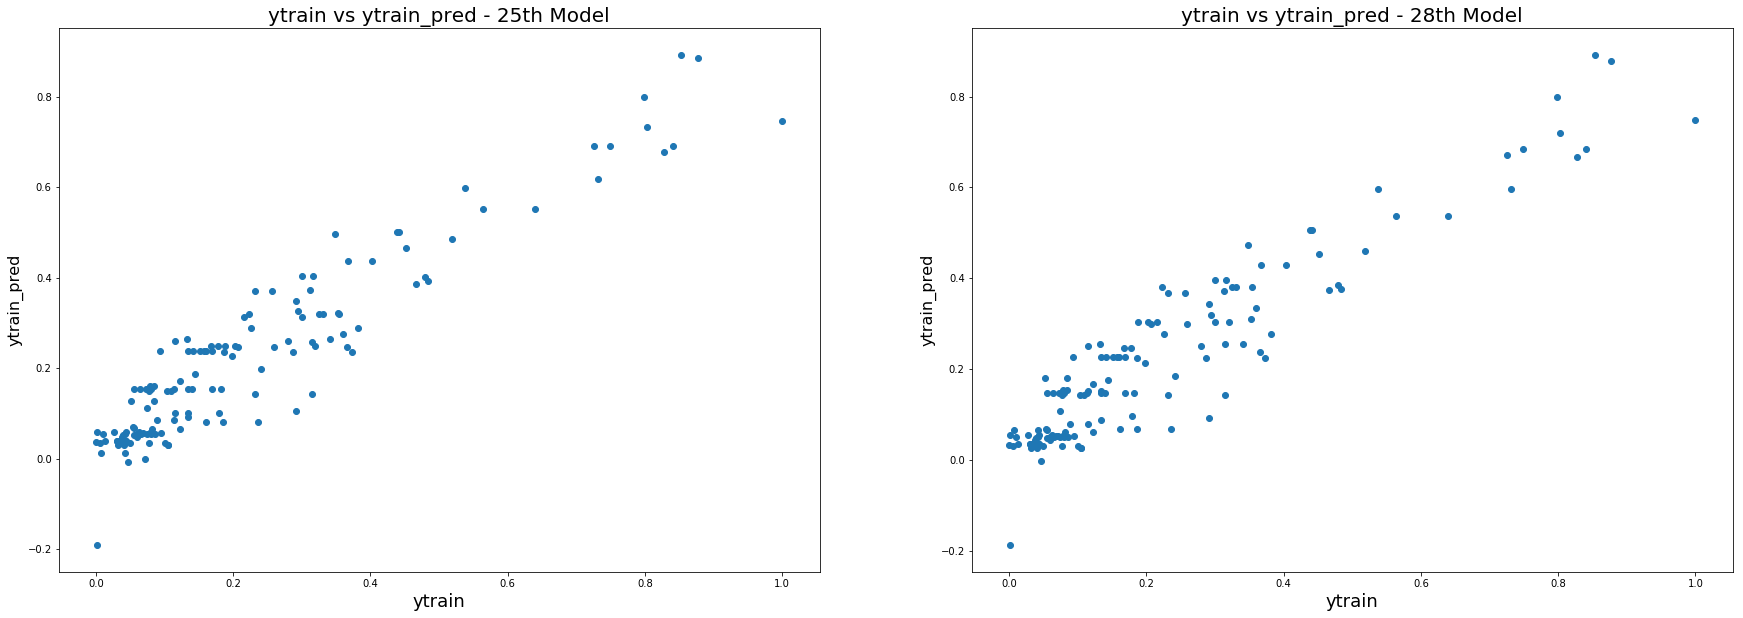

In [134]:
fig = plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.scatter(y_train,y_train25_pred)              # Plot heading 
plt.xlabel('ytrain', fontsize=18)                          # X-label
plt.ylabel('ytrain_pred', fontsize=16)                          # Y-label
plt.title('ytrain vs ytrain_pred - 25th Model', fontsize=20)
plt.subplot(1,2,2)
plt.scatter(y_train,y_train28_pred)              # Plot heading 
plt.xlabel('ytrain', fontsize=18)                          # X-label
plt.ylabel('ytrain_pred', fontsize=16)                          # Y-label
plt.title('ytrain vs ytrain_pred - 28th Model', fontsize=20)
plt.show()

#### Actual and Predicted

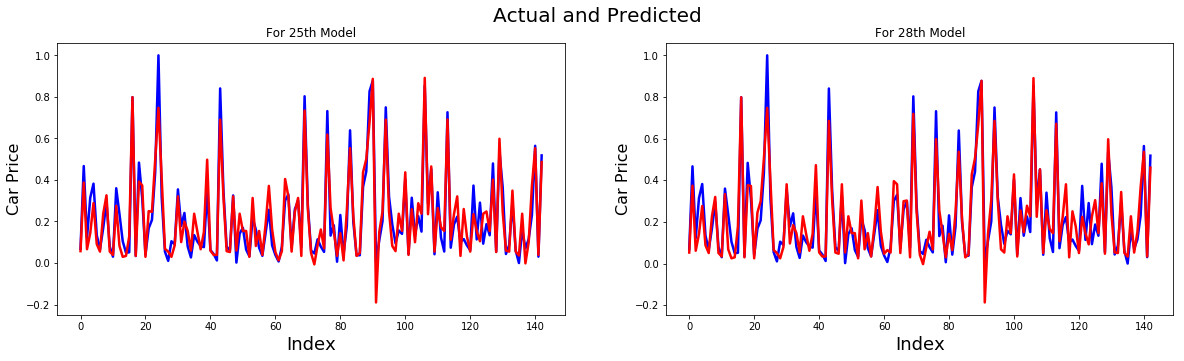

In [94]:
import matplotlib.pyplot as plt
c = [i for i in range(0,len(y_train.index),1)] # generating index 
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1,2,1)
plt.plot(c,y_train, color="blue", linewidth=2.5, linestyle="-") #Plotting Actual
plt.plot(c,y_train25_pred, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Car Price', fontsize=16)
plt.title('For 25th Model')
plt.subplot(1,2,2)
plt.plot(c,y_train, color="blue", linewidth=2.5, linestyle="-") #Plotting Actual
plt.plot(c,y_train28_pred, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Car Price', fontsize=16)    
plt.title('For 28th Model')
plt.show()

### Visualising Training Data -  Error terms

#### Calculating Error Terms 

In [95]:
error_train_terms25 = y_train - y_train25_pred
error_train_terms28 = y_train - y_train28_pred

In [96]:
print('Mean Squared Eror for training data using 25th Model : {:}'.format(mean_squared_error(y_train, y_train25_pred)))
print('Mean Squared Eror for training data using 28th Model : {:}'.format(mean_squared_error(y_train, y_train28_pred)))

Mean Squared Eror for training data using 25th Model : 0.005264989974514689
Mean Squared Eror for training data using 28th Model : 0.005696634551763612


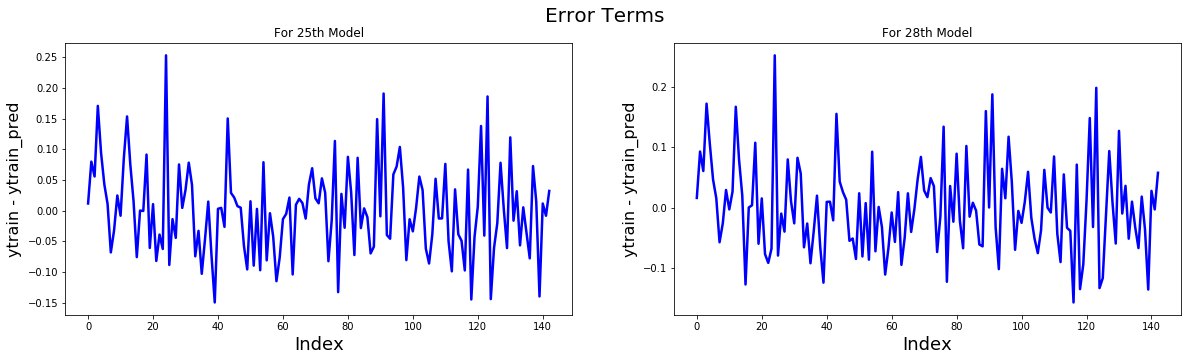

In [97]:
# Error terms
c = [i for i in range(0,len(error_train_terms25.index),1)]
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.subplot(1,2,1)
plt.plot(c, error_train_terms25, color="blue", linewidth=2.5, linestyle="-")
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytrain - ytrain_pred', fontsize=16)   
plt.title('For 25th Model')
plt.subplot(1,2,2)
plt.plot(c, error_train_terms28, color="blue", linewidth=2.5, linestyle="-")
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytrain - ytrain_pred', fontsize=16)   
plt.title('For 28th Model')
plt.show()

#### Validating Assumption - Error terms are normally distributed with mean zero

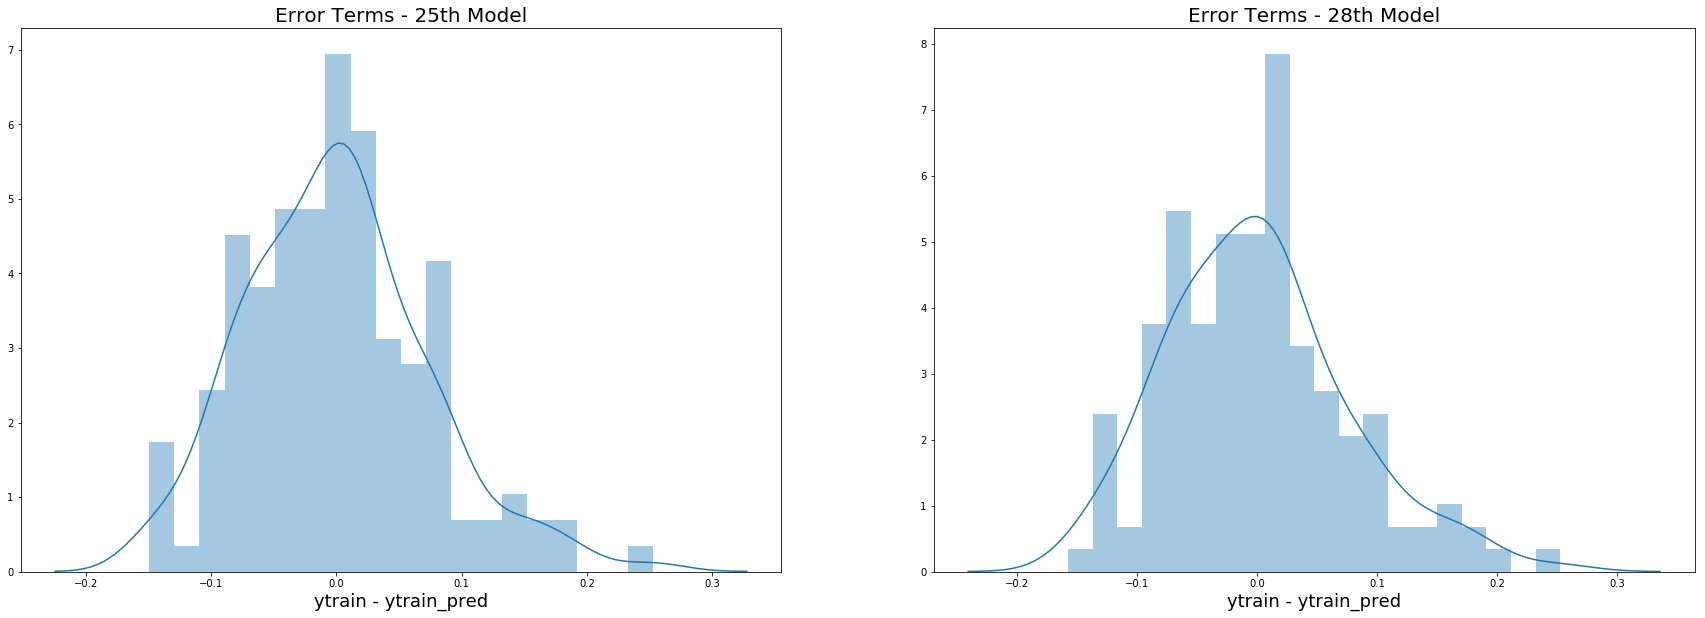

In [133]:
# Plot the histogram of the error terms
fig = plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.distplot(error_train_terms25, bins = 20)
plt.title('Error Terms - 25th Model', fontsize = 20)                  # Plot heading 
plt.xlabel('ytrain - ytrain_pred', fontsize = 18)  
plt.subplot(1,2,2)
sns.distplot(error_train_terms28, bins = 20)
plt.title('Error Terms - 28th Model', fontsize = 20)                  # Plot heading 
plt.xlabel('ytrain - ytrain_pred', fontsize = 18)  
plt.show()

#### Inference - Error Terms plot is normally distributed with mean at 0.0

#### Validating Assumption - Error Terms are independent of each other

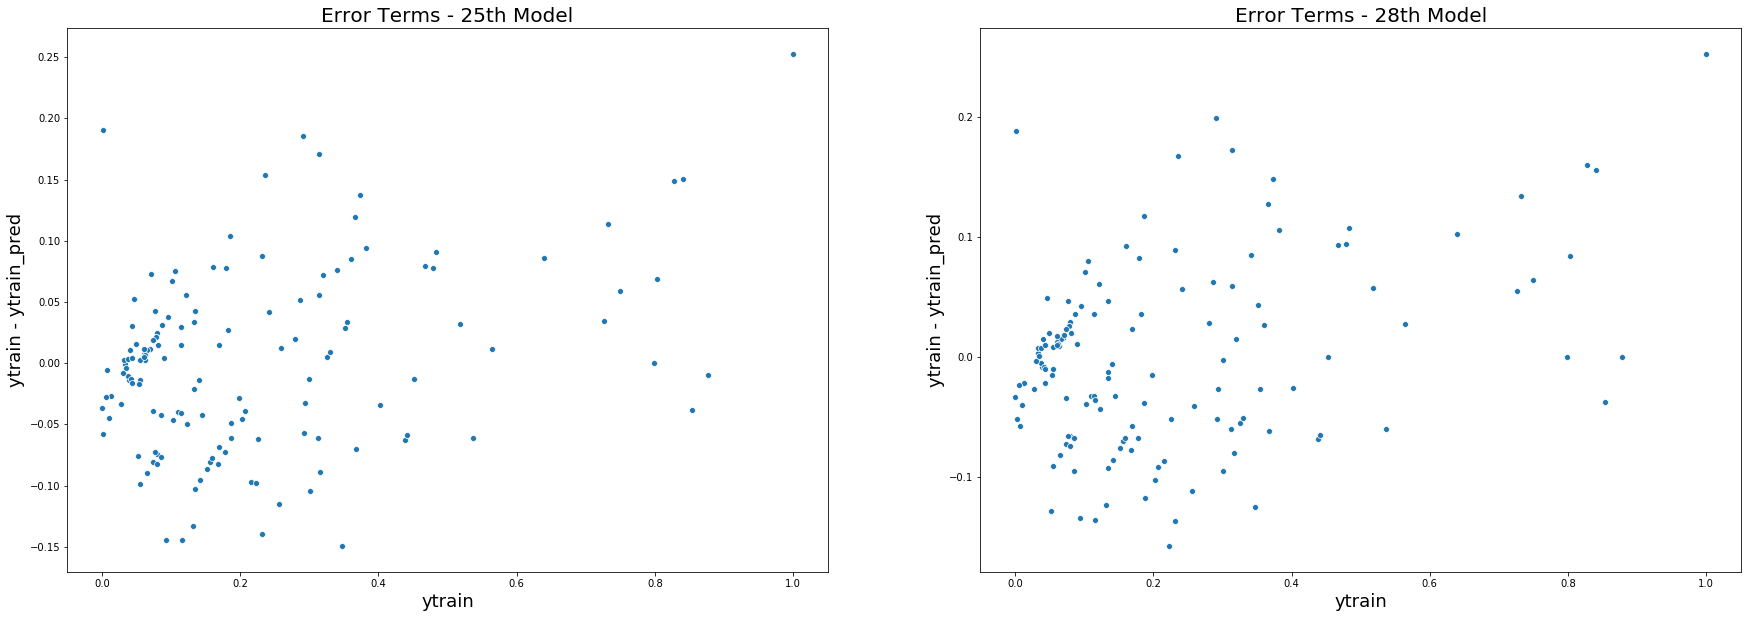

In [132]:
# Plot the scatter plot of the error terms to c
fig = plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.scatterplot(y_train, error_train_terms25)
plt.title('Error Terms - 25th Model', fontsize = 20)  
plt.xlabel('ytrain', fontsize = 18) 
plt.ylabel('ytrain - ytrain_pred', fontsize = 18)  
plt.subplot(1,2,2)
sns.scatterplot(y_train, error_train_terms28)
plt.title('Error Terms - 28th Model', fontsize = 20)   
plt.xlabel('ytrain', fontsize = 18) 
plt.ylabel('ytrain - ytrain_pred', fontsize = 18)  
plt.show()

#### Inference - Error Terms are independent of each other as there seems to be no visible pattern

## Step 7 - Making Predictions

### Applying scaling to test data

In [103]:
test_df[num_columns] = scalar.transform(test_df[num_columns])
test_df.describe()

,car_ID,symboling,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,...,carcompany_nissan,carcompany_peugeot,carcompany_plymouth,carcompany_porsche,carcompany_renault,carcompany_saab,carcompany_subaru,carcompany_toyota,carcompany_volkswagen,carcompany_volvo
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,...,62.000000,62.000000,62.000000,62.000000,62.0,62.000000,62.000000,62.000000,62.000000,62.000000
mean,0.550601,0.583871,0.564516,0.437764,0.559481,0.480376,0.559663,0.428470,0.232258,0.265673,...,0.064516,0.048387,0.048387,0.016129,0.0,0.048387,0.016129,0.193548,0.080645,0.080645
std,0.290690,0.271724,0.499868,0.212861,0.189947,0.165440,0.215811,0.179488,0.088288,0.162820,...,0.247676,0.216335,0.216335,0.127000,0.0,0.216335,0.127000,0.398304,0.274512,0.274512
min,0.014706,0.000000,0.000000,0.000000,0.056911,0.183333,0.141593,0.128394,0.200000,0.067925,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.323529,0.400000,0.000000,0.313793,0.459350,0.358333,0.384956,0.305275,0.200000,0.177358,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571078,0.600000,1.000000,0.387931,0.547967,0.441667,0.588496,0.406129,0.200000,0.226415,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.816176,0.800000,1.000000,0.570690,0.719919,0.516667,0.699115,0.564876,0.200000,0.316038,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.985294,1.000000,1.000000,1.182759,1.089431,0.975000,1.061947,0.935609,0.600000,0.932075,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


### Dividing into X_test and y_test

#### y_test

In [104]:
y_test = test_df.pop('price')

#### X_test for 25th Model

In [105]:
X_test25 = test_df[X_train25.columns]

#### X_test for 28th Model

In [106]:
X_test28 = test_df[X_train28.columns]

### Making Predictions using selected model

#### Using 25th Model

In [107]:
X_test25_sm = generate_x_sm(X_test25)
y_test25_pred = lr_model25.predict(X_test25_sm)

#### Using 28th Model

In [108]:
X_test28_sm = generate_x_sm(X_test28)
y_test28_pred = lr_model28.predict(X_test28_sm)

### Calculating r_squared

#### For 25th Model

In [109]:
r_squared_25 = r2_score(y_test, y_test25_pred)
print('R-squared for testing data using 25th Model : {:}'.format(r_squared_25))

R-squared for testing data using 25th Model : 0.8947159188297344


#### For 28th Model

In [110]:
r_squared_28 = r2_score(y_test, y_test28_pred)
print('R-squared for testing data using 25th Model : {:}'.format(r_squared_28))

R-squared for testing data using 25th Model : 0.8945476925367306


### Visualising Test Data -  Predicted Results vs Actual Values

#### Plotting ytest and ytest_pred to understand the spread

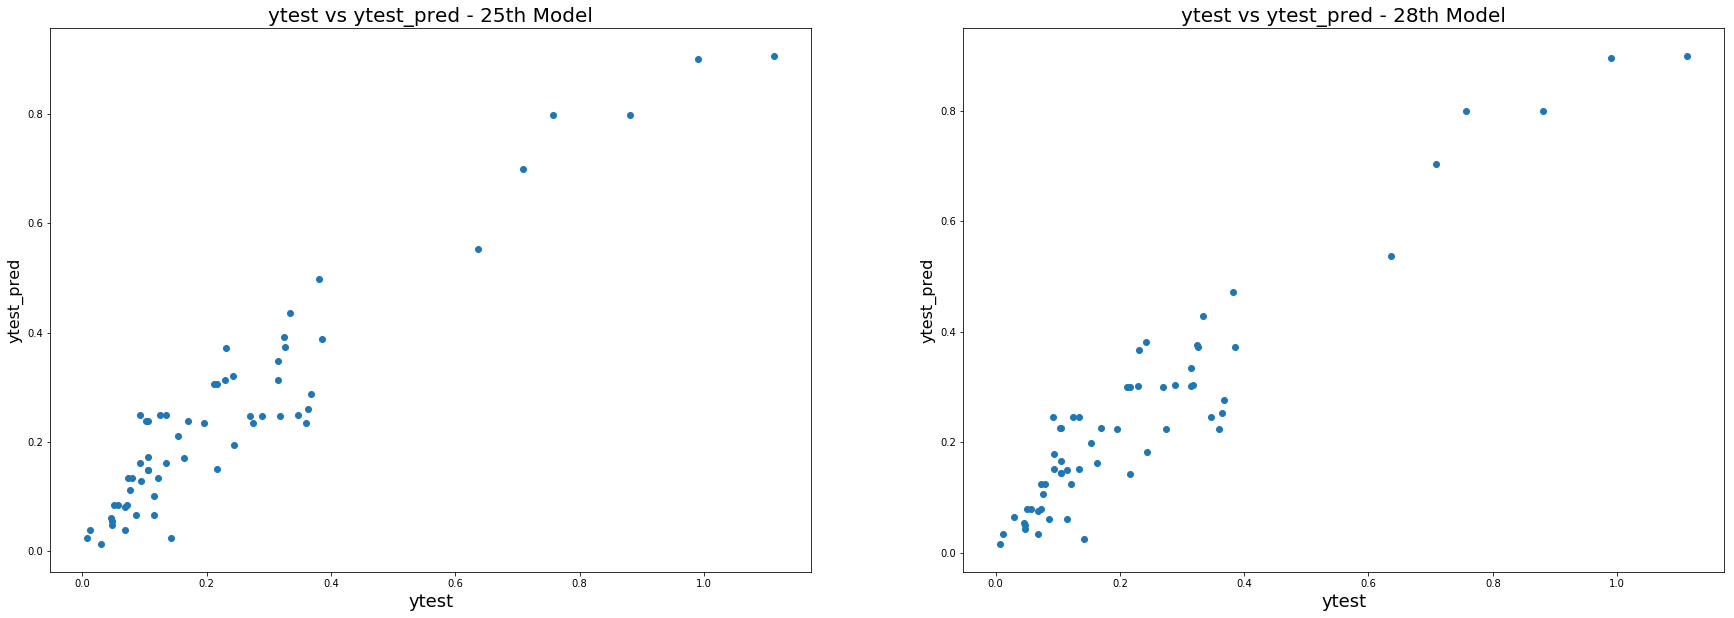

In [131]:
fig = plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.scatter(y_test,y_test25_pred)              # Plot heading 
plt.xlabel('ytest', fontsize=18)                          # X-label
plt.ylabel('ytest_pred', fontsize=16)                          # Y-label
plt.title('ytest vs ytest_pred - 25th Model', fontsize=20)
plt.subplot(1,2,2)
plt.scatter(y_test,y_test28_pred)              # Plot heading 
plt.xlabel('ytest', fontsize=18)                          # X-label
plt.ylabel('ytest_pred', fontsize=16)                          # Y-label
plt.title('ytest vs ytest_pred - 28th Model', fontsize=20)
plt.show()

#### Actual and Predicted

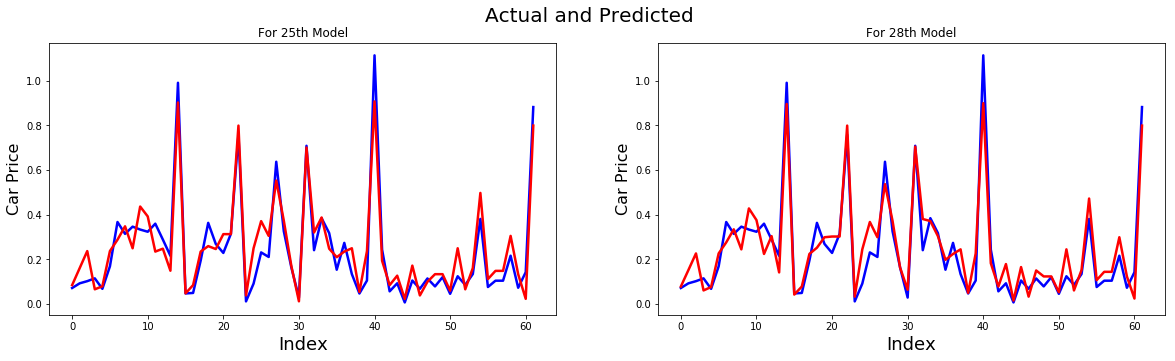

In [130]:
import matplotlib.pyplot as plt
c = [i for i in range(0,len(y_test.index),1)] # generating index 
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1,2,1)
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #Plotting Actual
plt.plot(c,y_test25_pred, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Car Price', fontsize=16)
plt.title('For 25th Model')
plt.subplot(1,2,2)
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #Plotting Actual
plt.plot(c,y_test28_pred, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Car Price', fontsize=16)    
plt.title('For 28th Model')
plt.show()

### Visualising Test Data -  Error terms

#### Calculating Error Terms 

In [113]:
error_test_terms25 = y_test - y_test25_pred
error_test_terms28 = y_test - y_test28_pred

In [114]:
print('Mean Squared Eror for testing data using 25th Model : {:}'.format(mean_squared_error(y_test, y_test25_pred)))
print('Mean Squared Eror for testing data using 28th Model : {:}'.format(mean_squared_error(y_test, y_test28_pred)))

Mean Squared Eror for testing data using 25th Model : 0.0056272483003174546
Mean Squared Eror for testing data using 28th Model : 0.005636239698740202


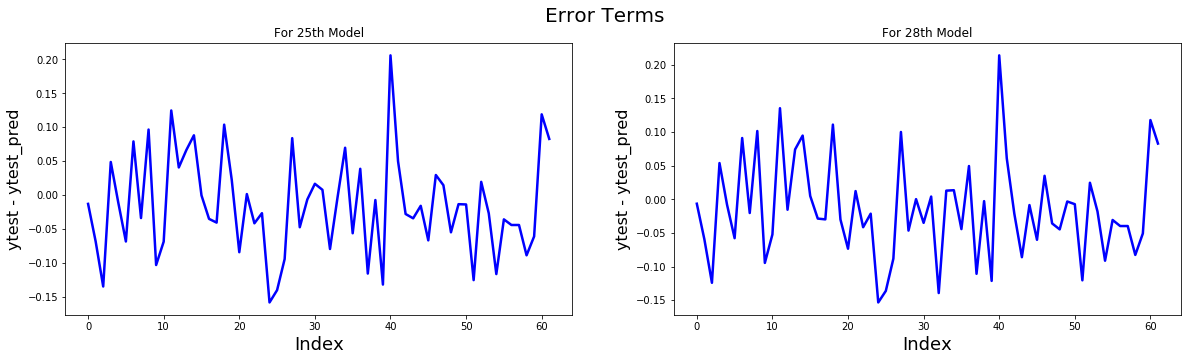

In [129]:
# Error terms
c = [i for i in range(0,len(error_test_terms25.index),1)]
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.subplot(1,2,1)
plt.plot(c, error_test_terms25, color="blue", linewidth=2.5, linestyle="-")
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest - ytest_pred', fontsize=16)   
plt.title('For 25th Model')
plt.subplot(1,2,2)
plt.plot(c, error_test_terms28, color="blue", linewidth=2.5, linestyle="-")
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest - ytest_pred', fontsize=16)   
plt.title('For 28th Model')
plt.show()

#### Validating Assumption - Error terms are normally distributed with mean zero

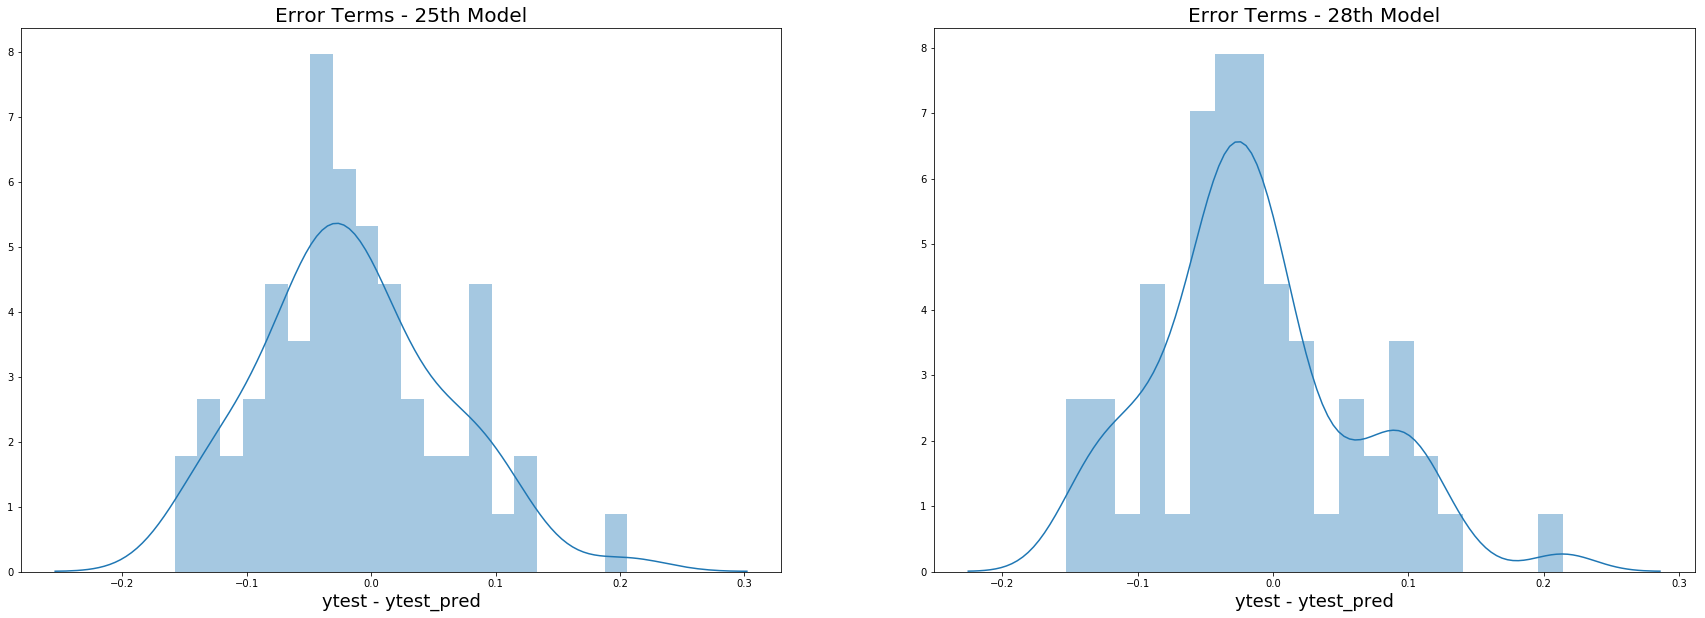

In [126]:
# Plot the histogram of the error terms
fig = plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.distplot(error_test_terms25, bins = 20)
plt.title('Error Terms - 25th Model', fontsize = 20)                  # Plot heading 
plt.xlabel('ytest - ytest_pred', fontsize = 18) 
plt.subplot(1,2,2)
sns.distplot(error_test_terms28, bins = 20)
plt.title('Error Terms - 28th Model', fontsize = 20)                  # Plot heading 
plt.xlabel('ytest - ytest_pred', fontsize = 18)  
plt.show()

#### Inference - Error Terms plot is normally distributed with mean at 0.0

#### Validating Assumption - Error Terms are independent of each other

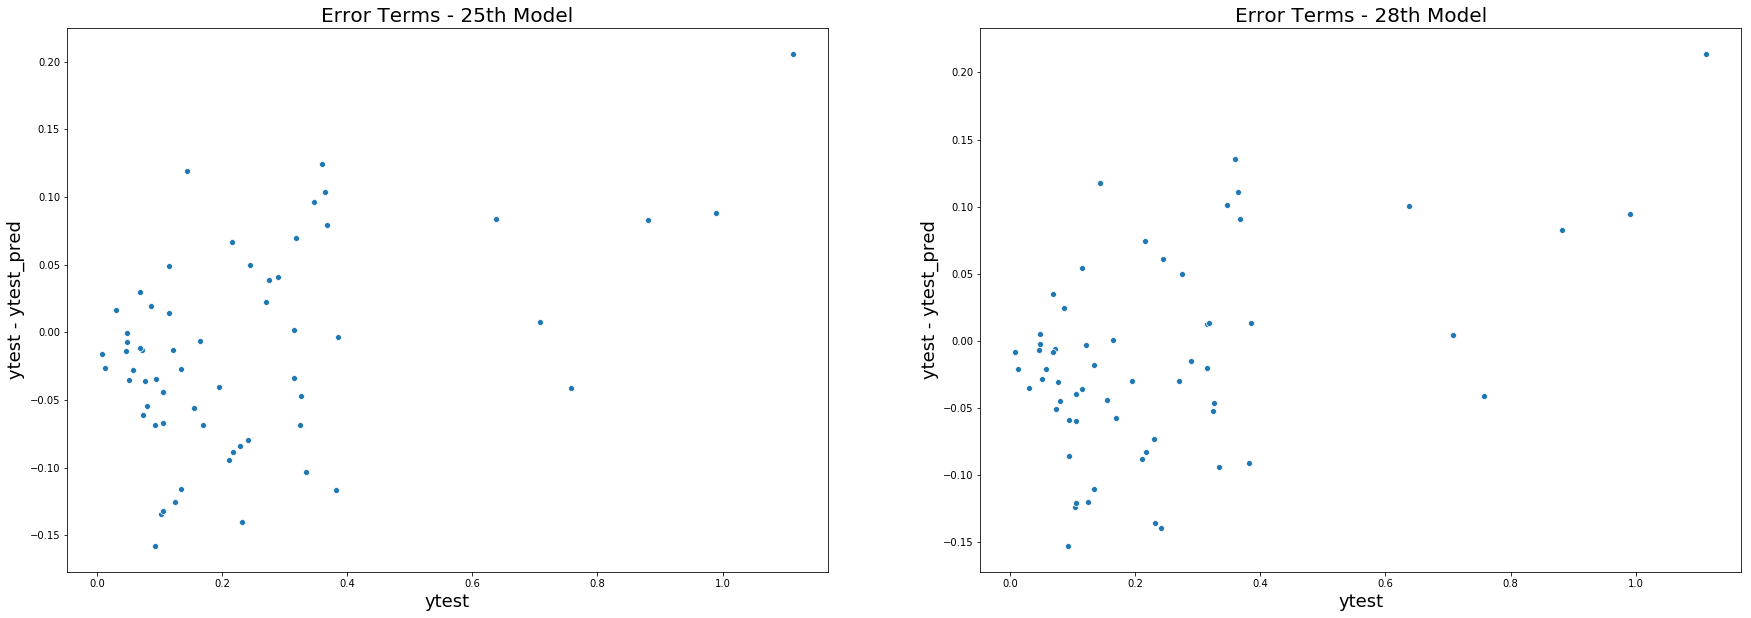

In [128]:
# Plot the scatter plot of the error terms to c
fig = plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.scatterplot(y_test, error_test_terms25)
plt.title('Error Terms - 25th Model', fontsize = 20)                  
plt.ylabel('ytest - ytest_pred', fontsize = 18)  
plt.xlabel('ytest', fontsize = 18) 
plt.subplot(1,2,2)
sns.scatterplot(y_test, error_test_terms28)
plt.title('Error Terms - 28th Model', fontsize = 20)   
plt.ylabel('ytest - ytest_pred', fontsize = 18) 
plt.xlabel('ytest', fontsize = 18)  
plt.show()

#### Inference - Error Terms are independent of each other as there seems to be no visible pattern

### Regression Plots

#### For 25th Model

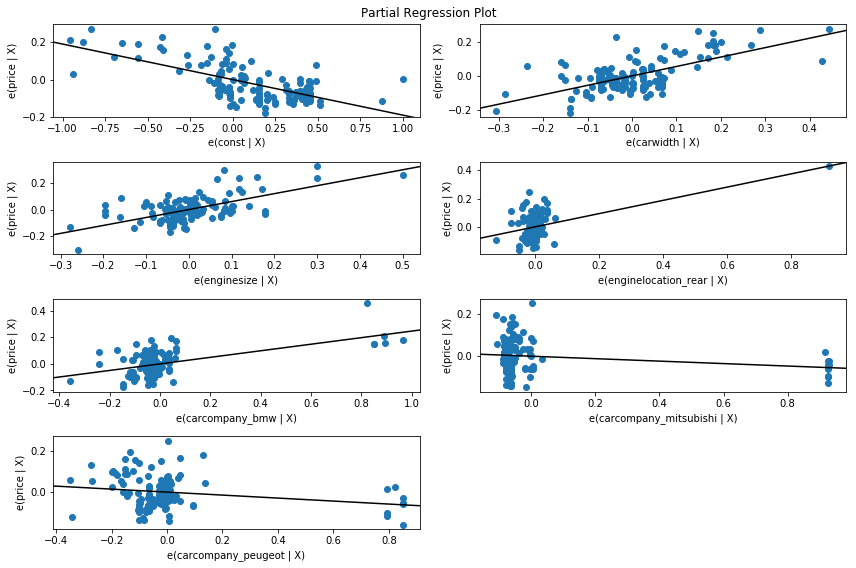

In [118]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(lr_model25, fig=fig)
plt.show()

#### For 28th Model

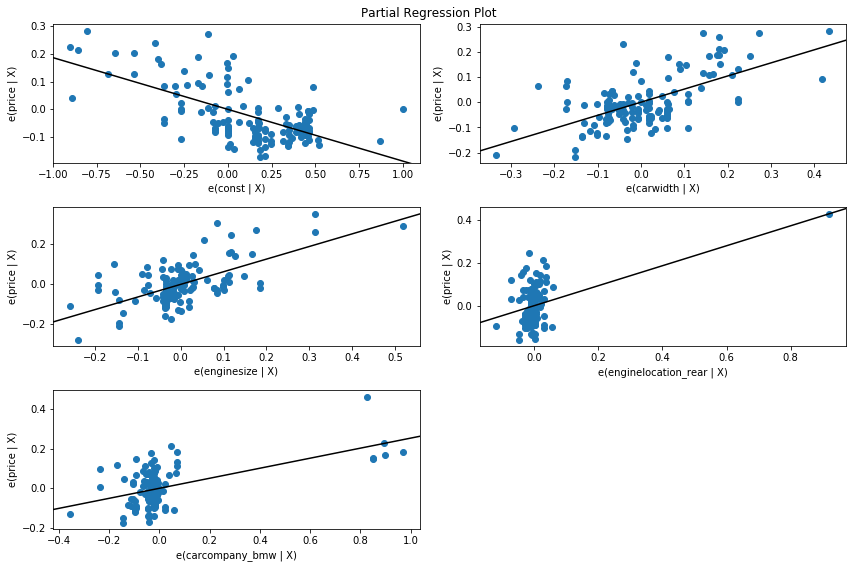

In [119]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(lr_model28, fig=fig)
plt.show()

### Residual Plots

#### For 25th Model

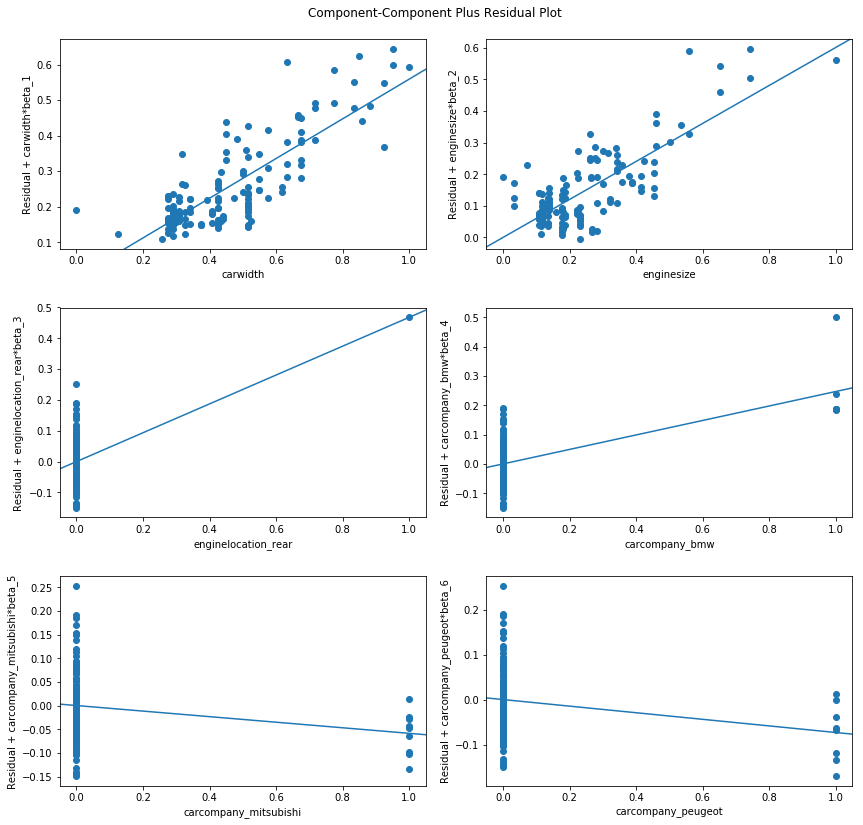

In [120]:
fig = plt.figure(figsize=(12, 15))
fig = sm.graphics.plot_ccpr_grid(lr_model25, fig=fig)

#### For 28th Model

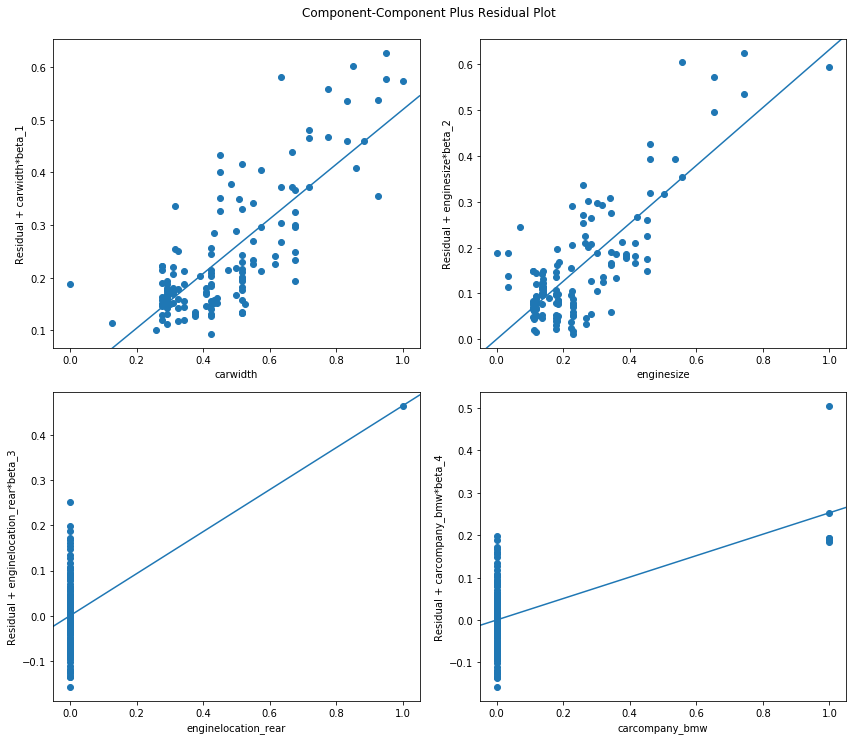

In [121]:
fig = plt.figure(figsize=(12, 15))
fig = sm.graphics.plot_ccpr_grid(lr_model28, fig=fig)

## Results

Based on residual analysis and test model evaluation, <b>28th model</b>
seems to be most optimised for predicting prices. Using <b>'carwidth', 'enginesize', 'enginelocation_rear', 'carcompany_bmw'</b> model is able to predict test data with r-squared value of 0.89454.

Here, <b>'carcompany_bmw', 'carcompany_mitsubishi', 'carcompany_peugeot'</b> represents brand value which are also significant in determinng the price. As noted, <b>'carcompany_mitsubishi', 'carcompany_peugeot'</b> is not as significant as <b>'carcompany_bmw'</b> in determining price which seems to be related to <b>'carcompany_bmw'</b> exceptional stand-out brand-value as compared to other brands. Geely Auto can spend on advertising to build brand value overtime and it should be considered in long-term business strategy.

<b>'enginelocation_rear'</b> represents if engine is present in rear or front of car. This is generally associated with targeted car-segment. For example, generally rear fitted engines comes in two seater high-end luxury cars. Geely Auto can consider this when deciding targeted car-segment.

Geely Auto can use <b>'carwidth', 'enginesize'</b> to devise effective business strategy for determining car prices when entering US market as these seems to be most significant in determining prices. 